In [59]:
using Random
using Distributions
using LinearAlgebra
using ForwardDiff
using KernelDensity
include("../Inversion/Plot.jl")
include("../Inversion/RWMCMC.jl")
include("../Inversion/SMC.jl")
include("../Inversion/KalmanInversion.jl")
include("../Inversion/IPS.jl")
include("../Inversion/GMGD.jl")

GMGD_Run (generic function with 3 methods)

# 1-Parameter Square Map
The posterior distribution is studied  numerically on the following nonlinear 1-parameter problem:

$$
\begin{equation*}
y = \mathcal{G}(\theta) + \eta \qquad \mathcal{G}(\theta) = \theta^2. 
\end{equation*}
$$    


We assume the observation is $y = 1$ and the piror is $\mathcal{N}(3, 2^2)$, we consider the following cases

$$
\begin{align*}
&A: \eta \sim \mathcal{N}(0, 1^2)\\
&B: \eta \sim \mathcal{N}(0, 0.5^2)\\
&C: \eta \sim \mathcal{N}(0, 0.2^2)\\
\end{align*}
$$ 

In [60]:
mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

function Setup_Param(N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], N_θ, N_y)
end

function p1(s_param, θ)  
    return [θ[1] ;]
end

function p1_aug(s_param, θ)  
    return [θ[1] ; θ[1]]
end

function p1_aug_derivative(s_param, θ)  
    return [θ[1] ; θ[1]], [1.0 ; 1.0]
end



function p2(s_param, θ)  
    return [θ[1]^2 ;]
end

function p2_aug(s_param, θ)  
    return [θ[1]^2 ; θ[1]]
end

function p2_aug_derivative(s_param, θ)  
    return [θ[1]^2 ; θ[1]], [2θ[1] ; 1.0]
end

p2_aug_derivative (generic function with 1 method)

In [66]:
function intp_kernel_1d(θ, xx = nothing; Nx=100,  preconditioner=false) 
    
    N_ens, N_θ = size(θ)
    if xx == nothing
        θ_min, θ_max = minimum(θ), maximum(θ)
        xx = reshape(Array(LinRange(θ_min - 0.1*(θ_max - θ_min), θ_max + 0.1*(θ_max - θ_min), Nx)), Nx, 1)
    else
        xx = reshape(xx, length(xx), 1)
    end
    # u_mean: N_par × 1
    θ_mean = construct_mean(θ)
    θθ_cov = construct_cov(θ, θ_mean, θ, θ_mean)
    Prec = (preconditioner ? θθ_cov : I)
    κ = kernel(θ, xx; C = (preconditioner ? θθ_cov : nothing) )
    
    xx = xx[:]
    yy = sum(κ, dims=1)[:]
    yy /= sum(yy)*(xx[2] - xx[1])
    return xx, yy
end



function Posterior_Plot(forward::Function;  θ_ref = 1.0, σ_η = 1.0, μ_0 = 3.0,  σ_0 = 2.0, mixture_power_sampling_method = "random-sampling",
                        Run_EKS = false, Run_SMC = false, Run_MCMC = false, Run_Fisher_Rao =false, plot_every = 1)

    forward_aug = (s_param, θ) -> vcat(forward(s_param, θ), θ)
    
    N_y, N_θ = 1, 1
    s_param = Setup_Param(N_θ, N_y)
    y = forward(s_param, [θ_ref;])
    Σ_η = reshape([σ_η^2], (N_y, N_y))
    # prior distribution
    μ0,  Σ0   = [μ_0;], reshape([σ_0^2],  (N_θ, N_θ))
    
    
    
    

    # compute posterior distribution by GMKI
    update_freq = 1
    N_iter = 30
    
    s_param_aug = Setup_Param(1,2)
    y_aug = [y ; μ0]
    Σ_η_aug = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y) Σ0]
    Δt = 0.5
    
    gmkiobjs = [] 
    for N_modes = 1:3
        
        θ0_w  = fill(1.0, N_modes)/N_modes
        θ0_mean, θθ0_cov  = zeros(N_modes, N_θ), zeros(N_modes, N_θ, N_θ)

        Random.seed!(111);
        for m = 1:N_modes
            θ0_mean[m, :]    .= rand(Normal(0, σ_0), N_θ)
            θθ0_cov[m, :, :] .= Array(Diagonal(fill(σ_0^2, N_θ)))
        end
        @info "Run GMKI with ", N_modes, " θ0_mean = ", θ0_mean
        gmkiobj = GMKI_Run(s_param_aug, forward_aug, θ0_w, θ0_mean, θθ0_cov, y_aug, Σ_η_aug, Δt, update_freq, N_iter; unscented_transform="modified-2n+1", mixture_power_sampling_method = mixture_power_sampling_method)
        push!(gmkiobjs, gmkiobj) 
    
    end


    if Run_MCMC
        # compute posterior distribution by MCMC
        logρ(θ) = log_bayesian_posterior(s_param, θ, forward, y, Σ_η, μ0, Σ0) 
        step_length = 1.0
        n_iter , n_burn_in= 5000000, 1000000
        us = RWMCMC_Run(logρ, μ0, step_length, n_iter)
    end
    
    # compute posterior distribution by SMC
    if Run_SMC
        N_ens = 100
        M_threshold = Float64(N_ens)
        step_length = 1.0
        smcobj = SMC_Run(s_param, forward,
        μ0, Σ0, 
        y, Σ_η,
        N_ens, 
        step_length,
        M_threshold,
        N_iter) 
    end

    if Run_EKS
        N_ens  = 1000
        eksobj = EKS_Run(s_param, forward, 
        μ0, Σ0,
        N_ens,
        y, Σ_η,
        N_iter)
        @info "EKS large J t = ", sum(eksobj.Δt)
    end
    
    if Run_Fisher_Rao
        N_ens  = 100
        method  = "Wasserstein"
        preconditioner = true             # true
        Δt, N_t = 1e-3/5, 100
        
        logρ = θ ->log_bayesian_posterior(s_param, θ, forward, y, Σ_η, μ0, Σ0)
        
        function compute_∇logρ(s_param, θ)
            return logρ(θ), ForwardDiff.gradient(logρ, θ)
        end   
        θ0 = Array(rand(MvNormal(μ0, Σ0), N_ens)')   
        ipsobj = IPS_Run(s_param, compute_∇logρ, θ0, N_ens, Δt, N_t, method, preconditioner)
        
    end
    
        
    Nx = 1000
    θ_min = minimum(gmkiobjs[end].θ_mean[end][:,1] .- 5sqrt.(gmkiobjs[end].θθ_cov[end][:,1,1]))
    θ_max = maximum(gmkiobjs[end].θ_mean[end][:,1] .+ 5sqrt.(gmkiobjs[end].θθ_cov[end][:,1,1]))

    # Plot reference
    xx_ref = Array(LinRange(θ_min, θ_max, 1000))
    yy_ref = copy(xx_ref)
    for i = 1:length(xx_ref)
        y_pred = forward(s_param, [xx_ref[i];])[1]
        yy_ref[i] = exp( - 0.5*(y_pred - y[1])^2/σ_η^2  - 0.5*(xx_ref[i] - μ_0)^2/σ_0^2 )
    end
    yy_ref .= yy_ref / ( sum(yy_ref)*(xx_ref[2] - xx_ref[1]) )
           
    
    
    # visualization 
    plot_every = 10
    linestyles = ["o"; "x"; "s"]
    # Visualize different iterations
    for iter  = [1:plot_every:N_iter; N_iter]
        nrows, ncols = 2, 3
        fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=false, sharey="row", figsize=(15,10))
        
        
        # plot UKI results 
        for N_modes = 1:3
            
            # Plot reference
            ax[1, N_modes].plot(xx_ref, yy_ref, "-s", label="Reference", color="grey", linewidth=2, fillstyle="none", markevery=25)
           
            
            
            if Run_MCMC
                # plot MCMC results 
                ax[1, N_modes].hist(us[n_burn_in:end, 1], bins = 100, density = true, histtype = "step", label="MCMC", color="grey", linewidth=2)
            end


            if Run_SMC
                # plot SMC results 
                θ = smcobj.θ[end]
                weights = smcobj.weights[end]
                ax[1, N_modes].hist(θ, bins = 10, weights = weights, density = true, histtype = "step", label="SMC", color="maroon")  
            end
            
            
            if Run_EKS
                # plot EKS results 
                θ = eksobj.θ[end]
                ax[1, N_modes].hist(θ, bins = 40, density = true, histtype = "step", label="EKS", color="C4")
            end

            
            if Run_Fisher_Rao
                # plot EKS results 
                θ = ipsobj.θ[end]
                xx_FR, yy_FR = intp_kernel_1d(θ, xx_ref)
                ax[1, N_modes].plot(xx_FR, yy_FR, "--", label="WFR", color="C5")
                
                @info "L2 error = ", norm(yy_ref - yy_FR, 1)*(xx_FR[2] - xx_FR[1])
            end
            
            
            
            Nx = 1000
            xxs, zzs = zeros(N_modes, Nx), zeros(N_modes, Nx)
            θ_min = minimum(gmkiobjs[N_modes].θ_mean[iter][:,1] .- 5sqrt.(gmkiobjs[N_modes].θθ_cov[iter][:,1,1]))
            θ_max = maximum(gmkiobjs[N_modes].θ_mean[iter][:,1] .+ 5sqrt.(gmkiobjs[N_modes].θθ_cov[iter][:,1,1]))            
            
            
            for i =1:N_modes
                xxs[i, :], zzs[i, :] = Gaussian_1d(gmkiobjs[N_modes].θ_mean[iter][i,1], gmkiobjs[N_modes].θθ_cov[iter][i,1,1], Nx, θ_min, θ_max)
                zzs[i, :] *= exp(gmkiobjs[N_modes].logθ_w[iter][i])
                
                ax[1, N_modes].plot(fill(gmkiobjs[N_modes].θ_mean[iter][i,1], 11), LinRange(0,1,11), marker=linestyles[i], fillstyle="none", markevery=5, color="C"*string(i))


                # ax[1, N_modes].plot(xxs[i,:], zzs[i,:], marker= linestyles[i], linestyle=":", color="C"*string(i), fillstyle="none", markevery=100, label="modal "*string(i))
            end
            ax[1, N_modes].plot(xxs[1,:], sum(zzs, dims=1)', linestyle="-", color="C0", fillstyle="none", markevery=100, label="GMKI", linewidth=2)
        


            ax[1, N_modes].legend()
            
            
            θ_w = exp.(hcat(gmkiobjs[N_modes].logθ_w...))
            for i =1:N_modes
                ax[2, N_modes].plot(Array(1:N_iter), θ_w[i, 1:N_iter], marker=linestyles[i], color = "C"*string(i), fillstyle="none", markevery=5, label= "mode "*string(i))
            end
            ax[2, N_modes].legend()
            ax[2, N_modes].set_xlabel("Iterations")
        end
        ax[1, 1].set_ylabel("Densities")
        ax[2, 1].set_ylabel("Weights")
        
        fig.tight_layout()
        fig.savefig("1D-density-"*string(σ_η)*"-"*string(iter)*".pdf")
    end
    
    
    
end

mixture_power_sampling_method = "random-sampling"

"random-sampling"

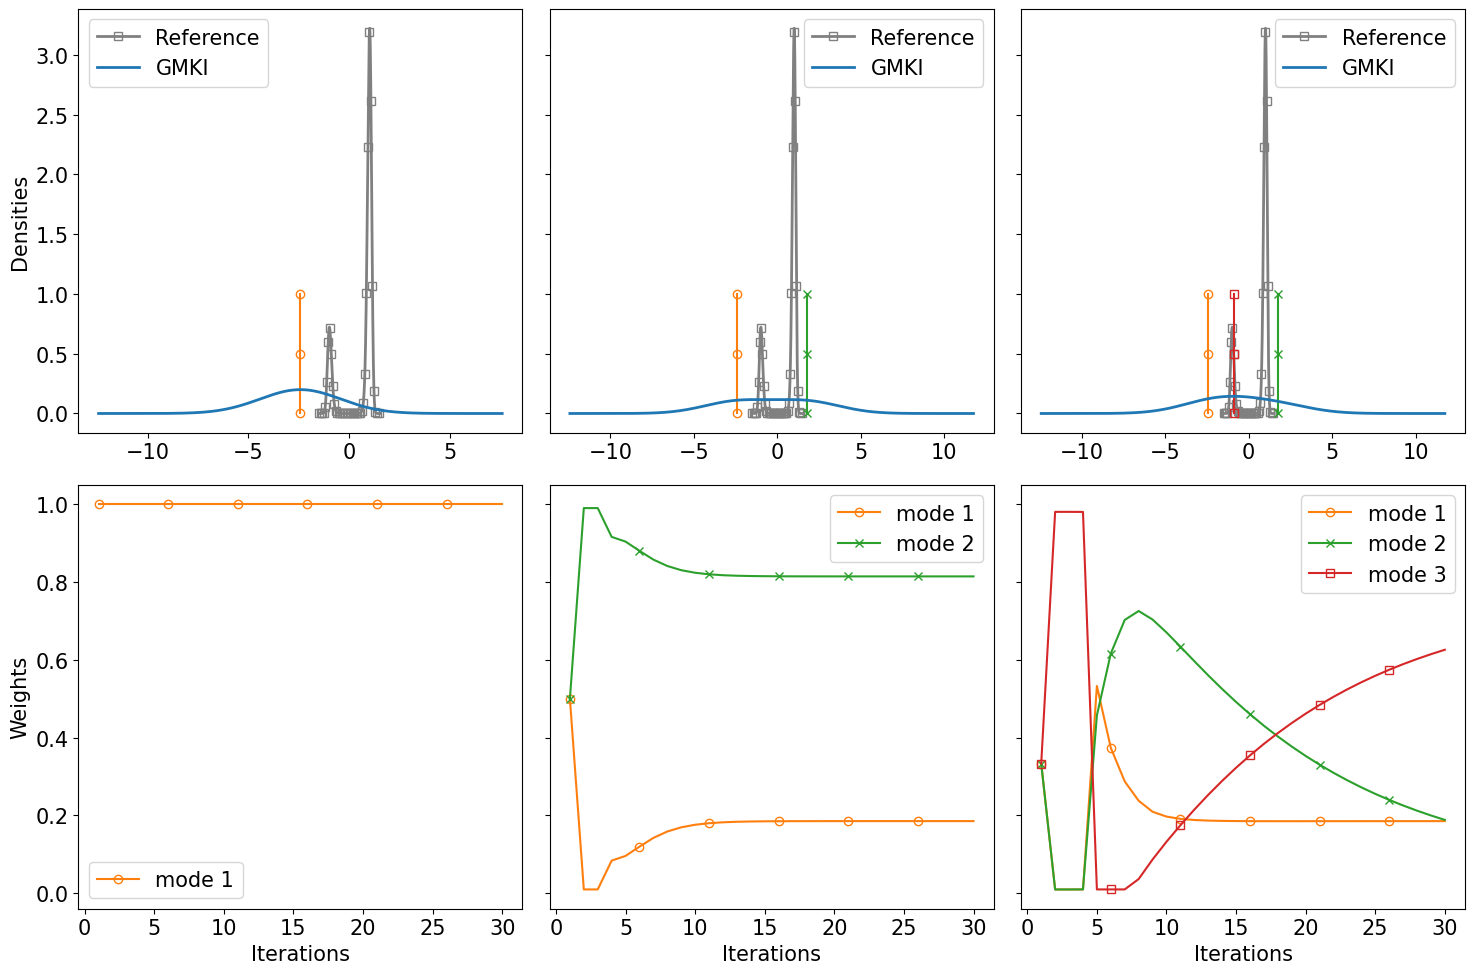

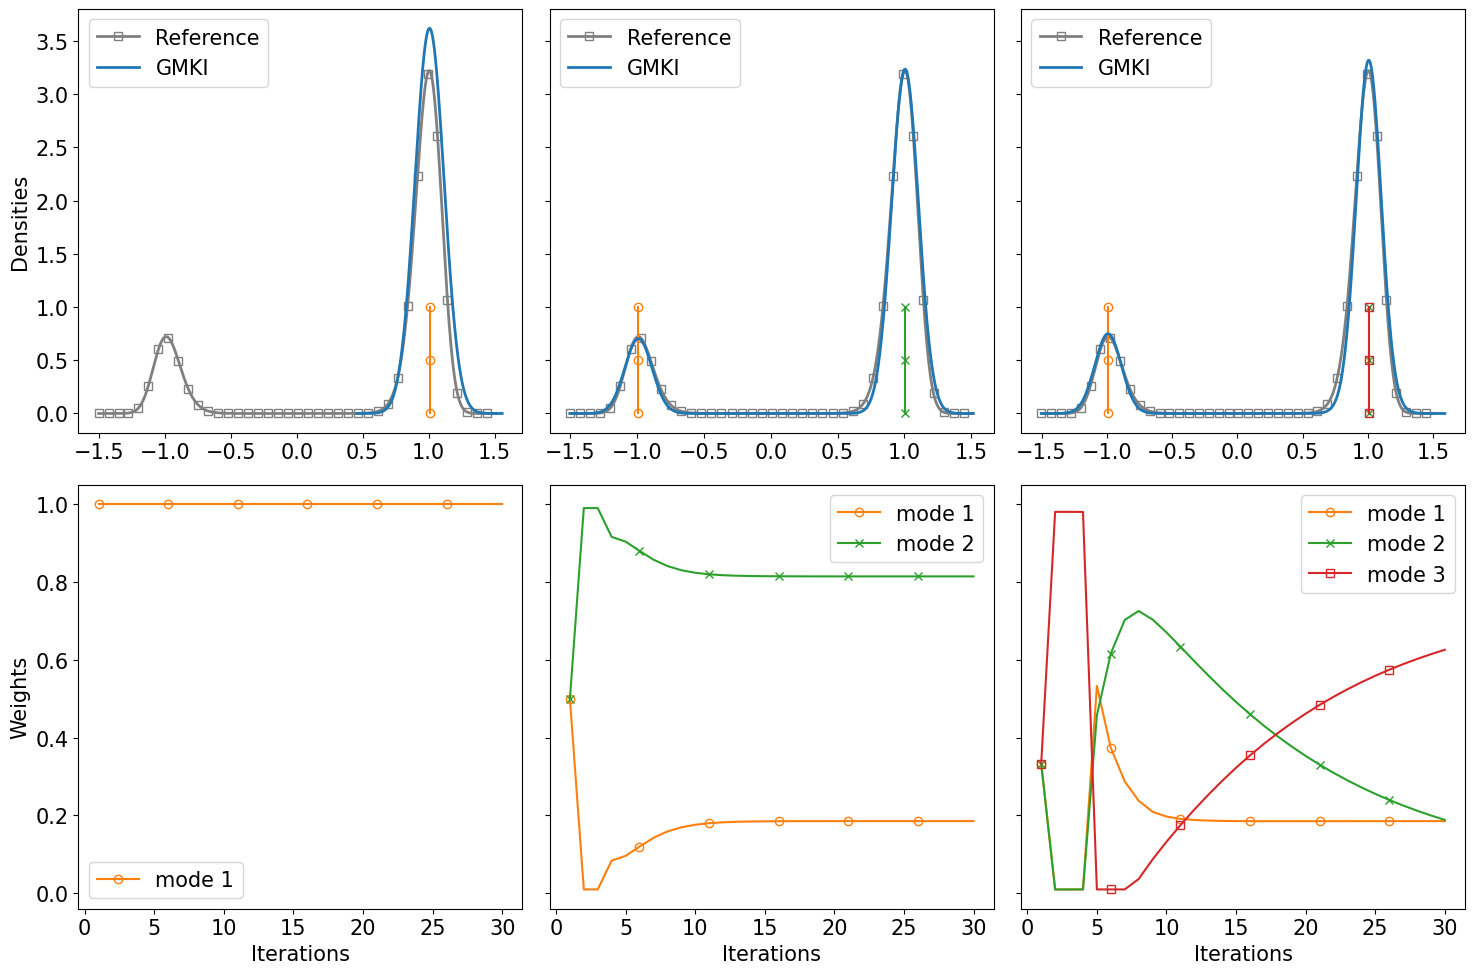

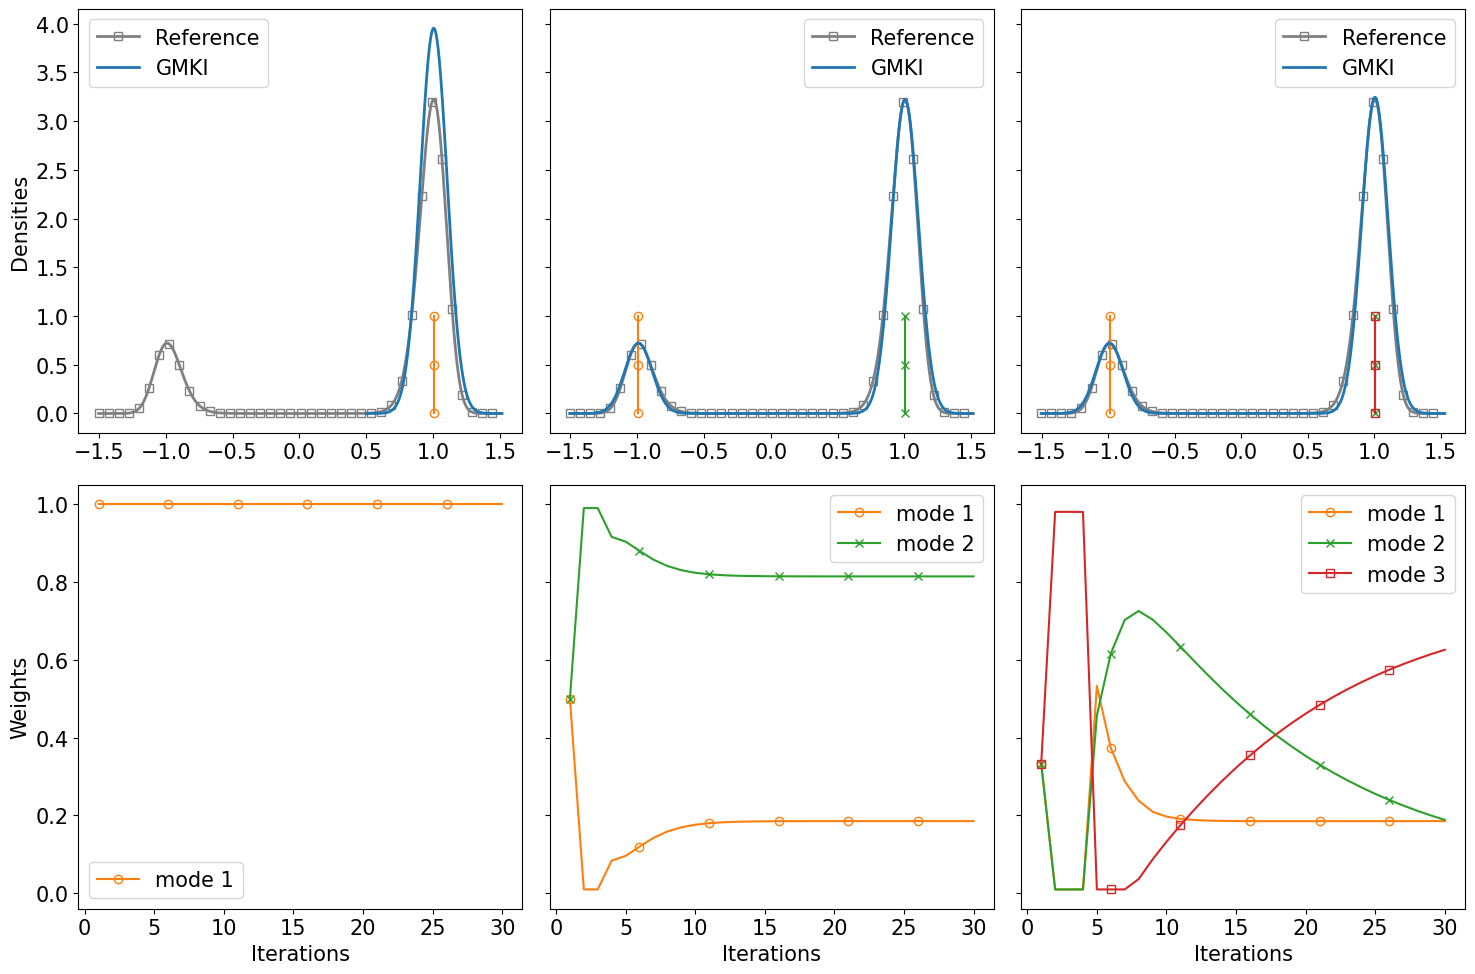

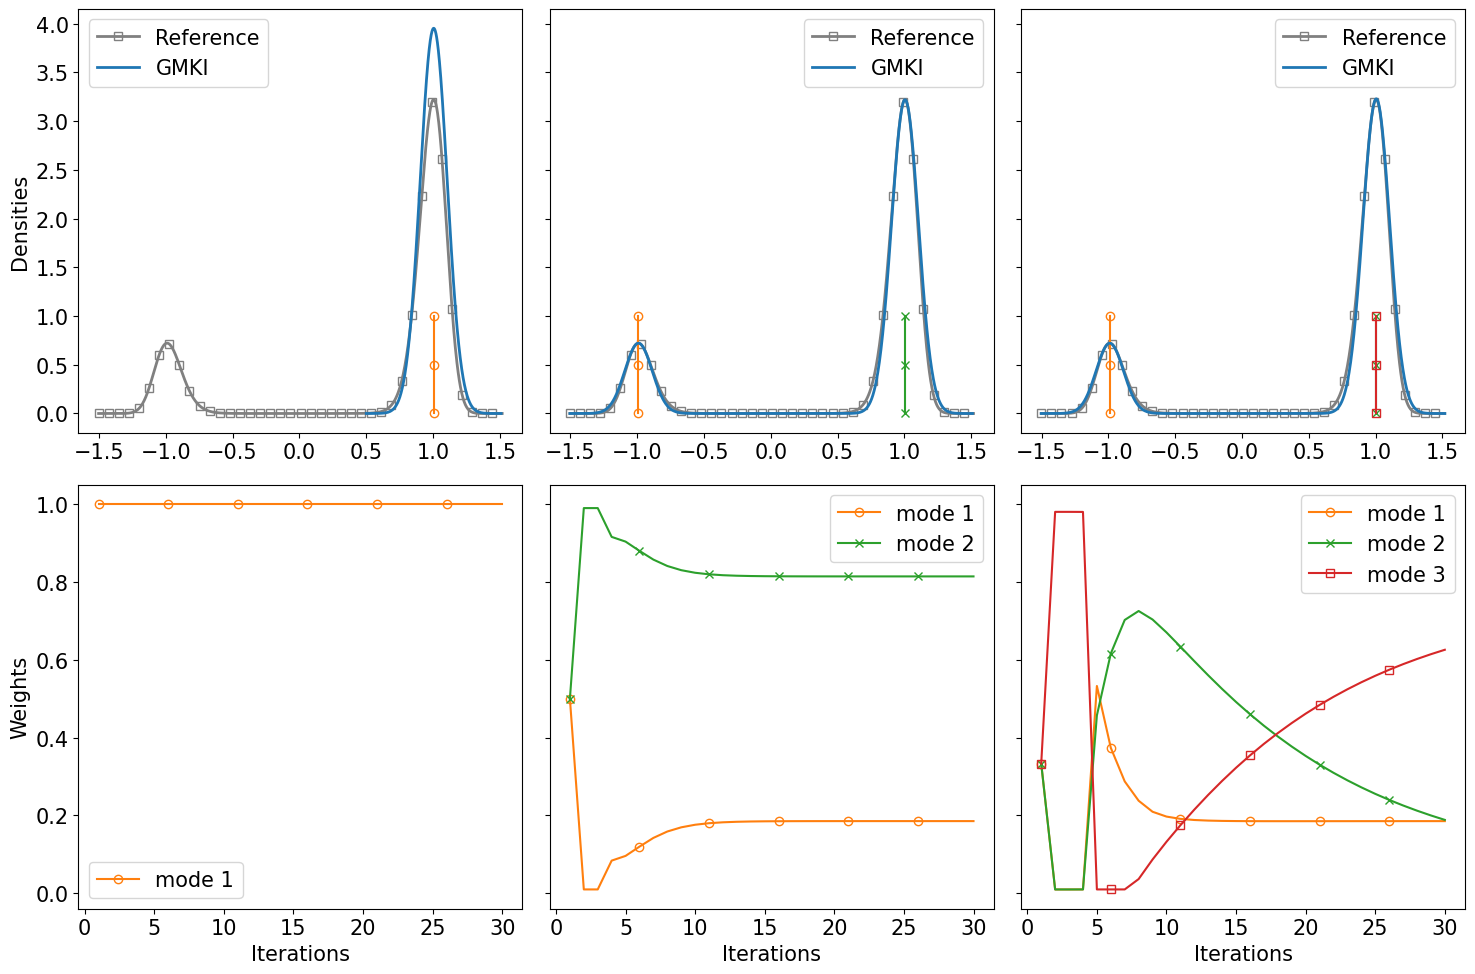

┌ Info: ("Run GMKI with ", 1, " θ0_mean = ", [-2.4283140297584804;;])
└ @ Main In[66]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:123
┌ Info: ("Run GMKI with ", 2, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095;;])
└ @ Main In[66]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:123
┌ Info: ("Run GMKI with ", 3, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095; -0.894645096090581;;])
└ @ Main In[66]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:123


In [67]:

Posterior_Plot(p2; θ_ref = 1.0, σ_η = 0.2, μ_0 = 3.0,  σ_0 = 2.0, Run_Fisher_Rao = false, plot_every = 5, mixture_power_sampling_method = mixture_power_sampling_method) 

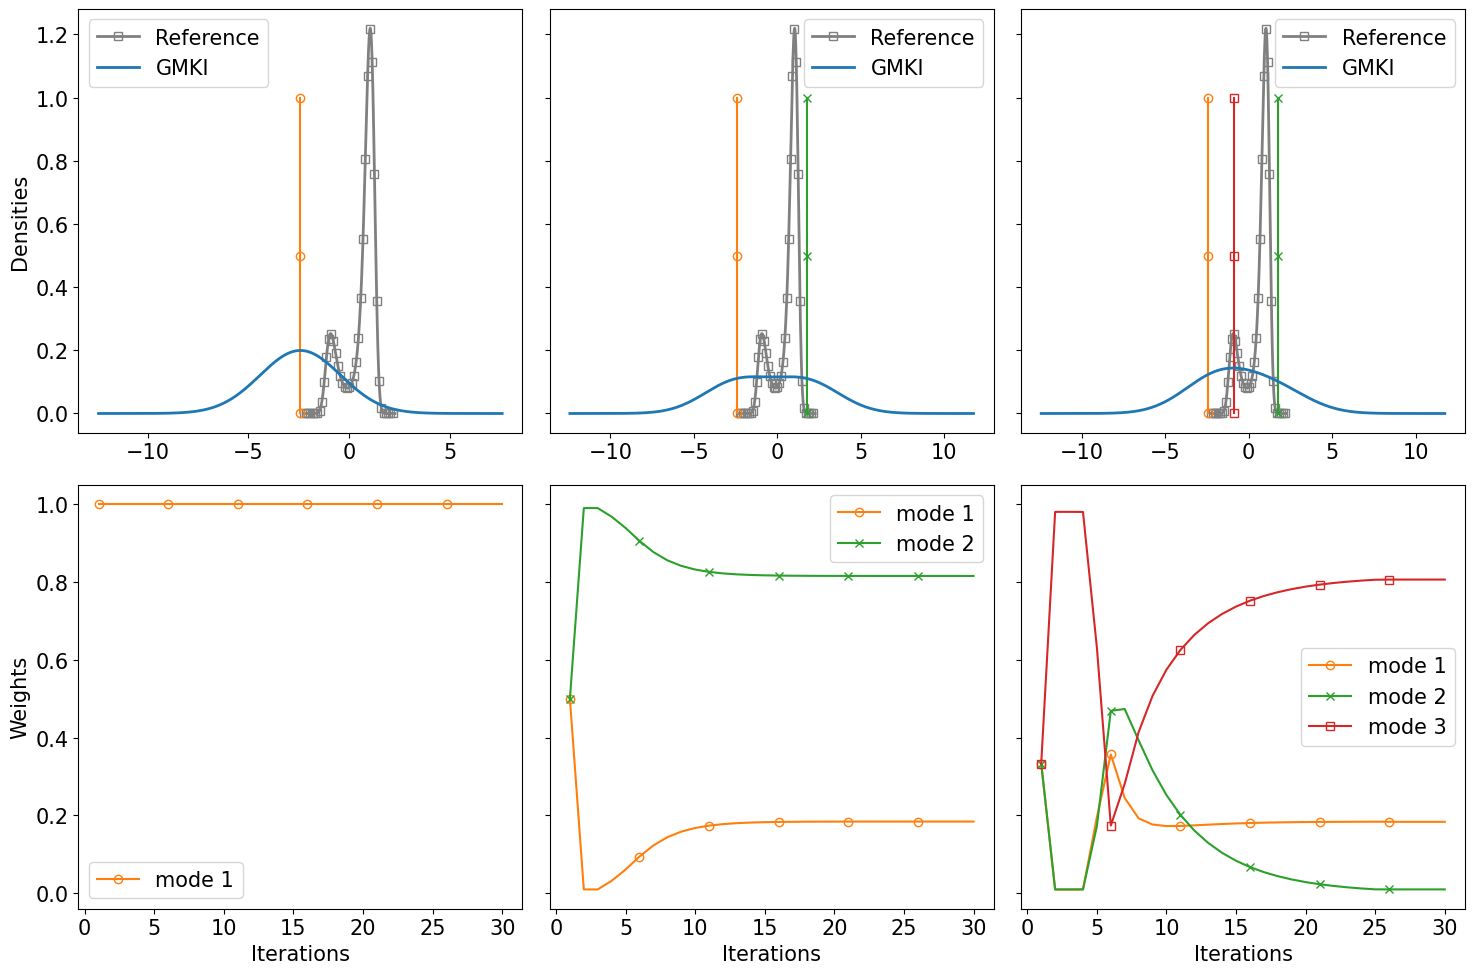

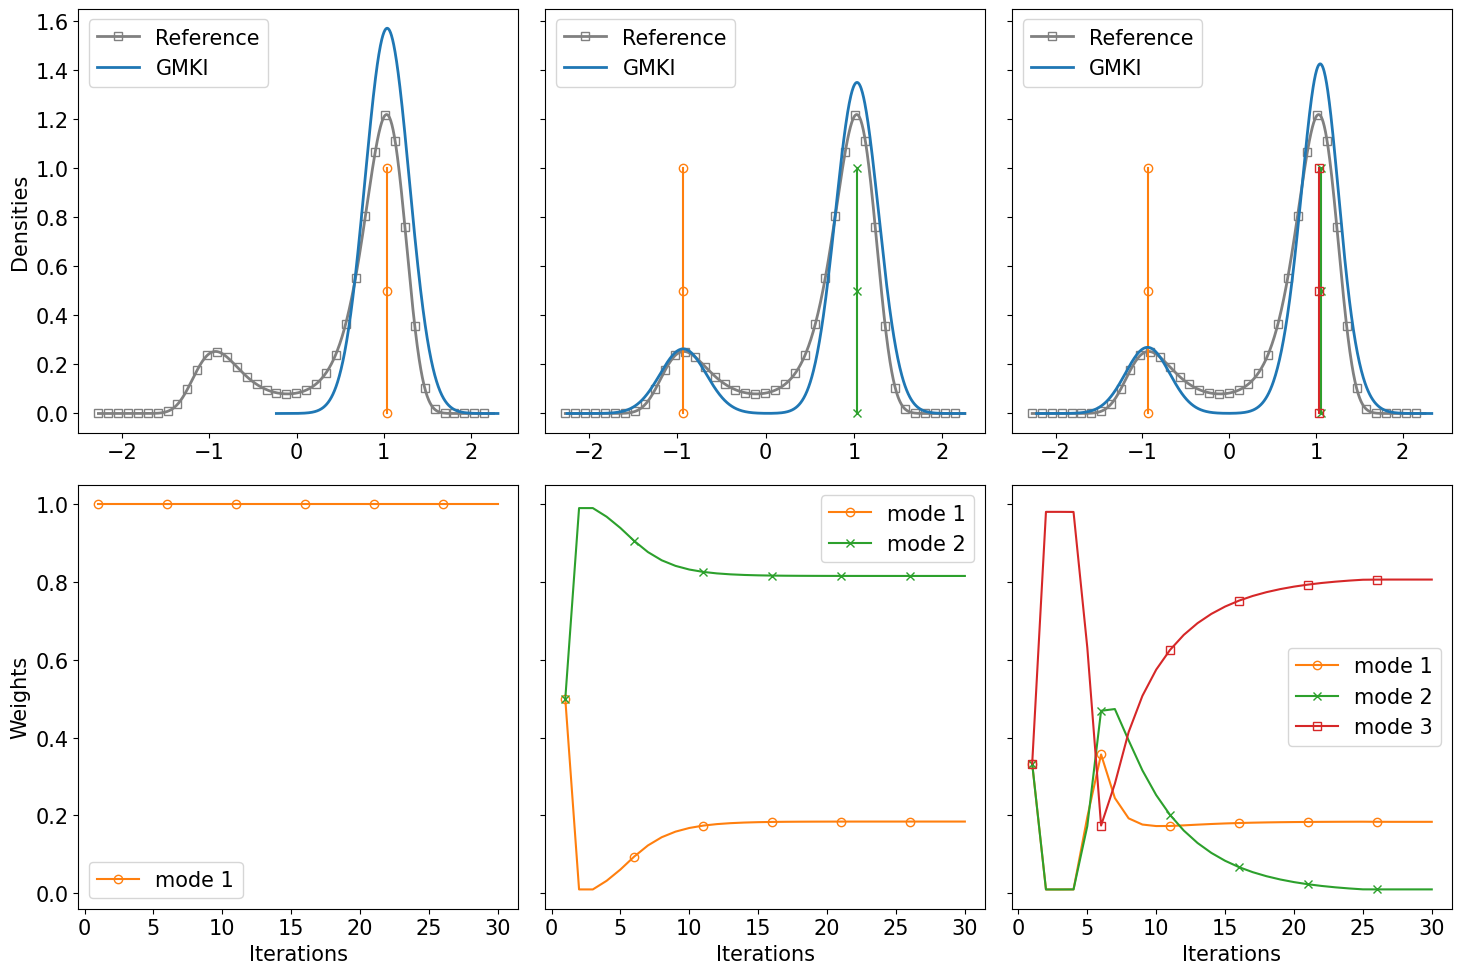

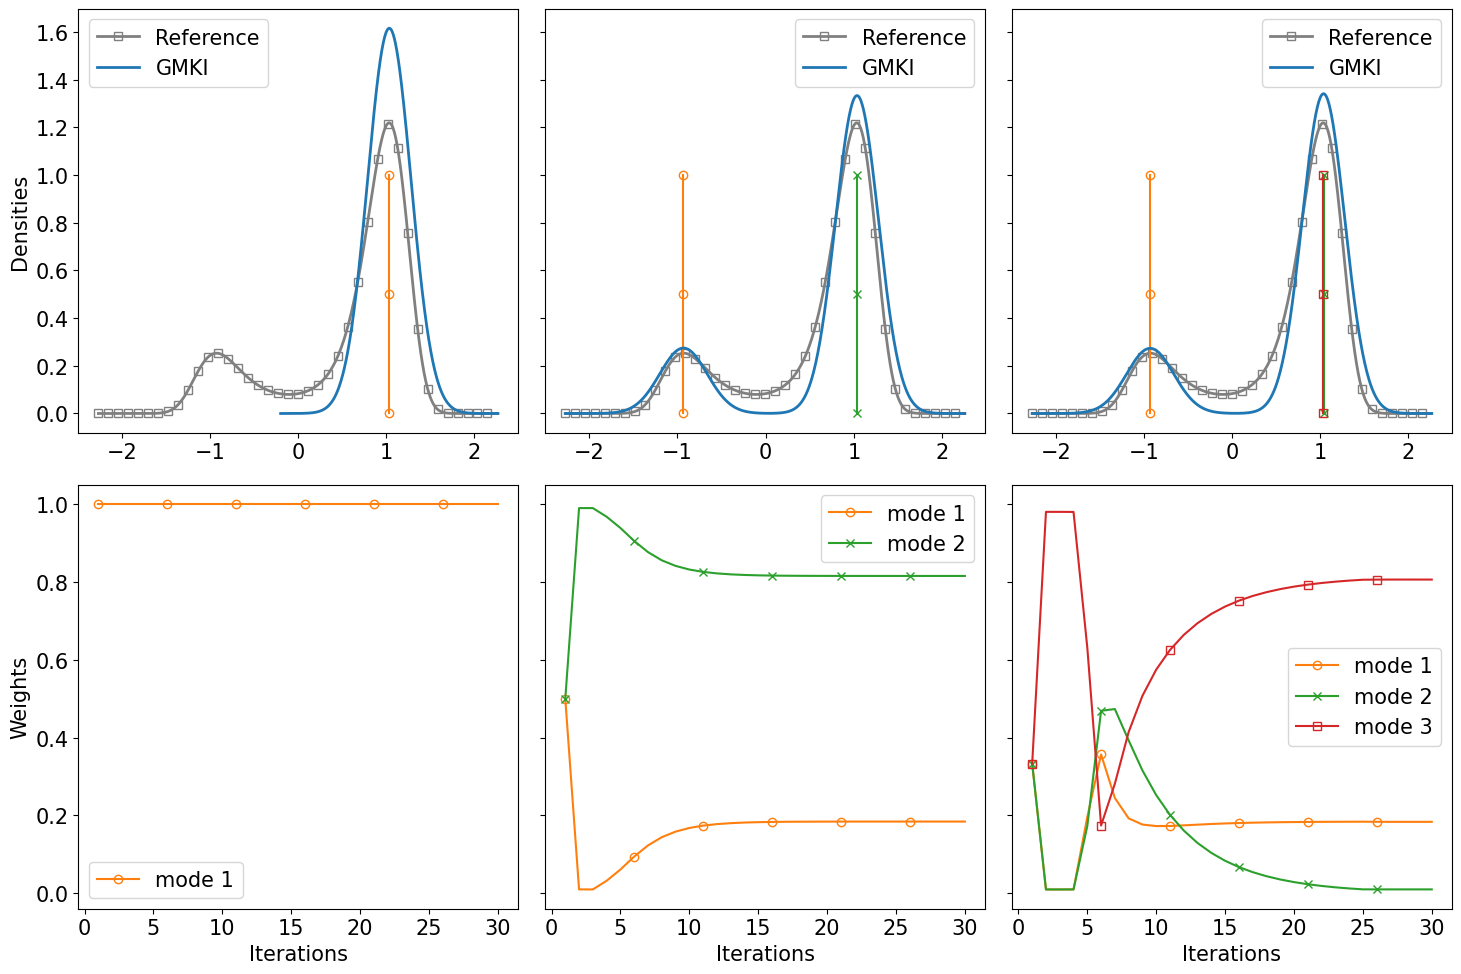

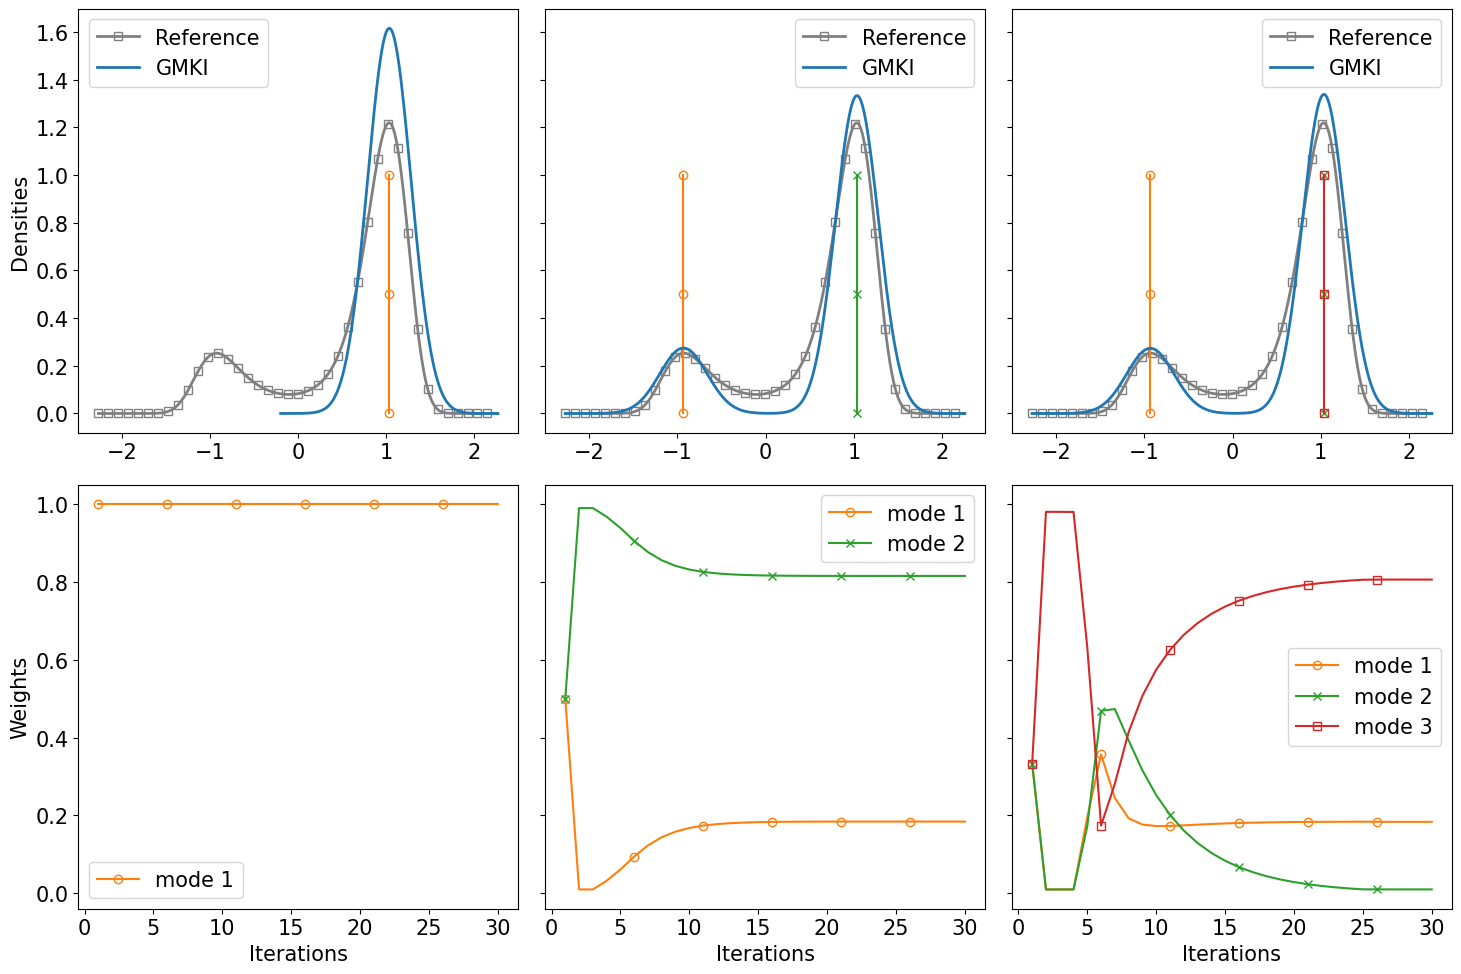

┌ Info: ("Run GMKI with ", 1, " θ0_mean = ", [-2.4283140297584804;;])
└ @ Main In[66]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:123
┌ Info: ("Run GMKI with ", 2, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095;;])
└ @ Main In[66]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:123
┌ Info: ("Run GMKI with ", 3, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095; -0.894645096090581;;])
└ @ Main In[66]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:123


In [68]:
Posterior_Plot(p2; θ_ref = 1.0, σ_η = 0.5, μ_0 = 3.2,  σ_0 = 2.0, Run_Fisher_Rao = false, plot_every = 5, mixture_power_sampling_method = mixture_power_sampling_method) 

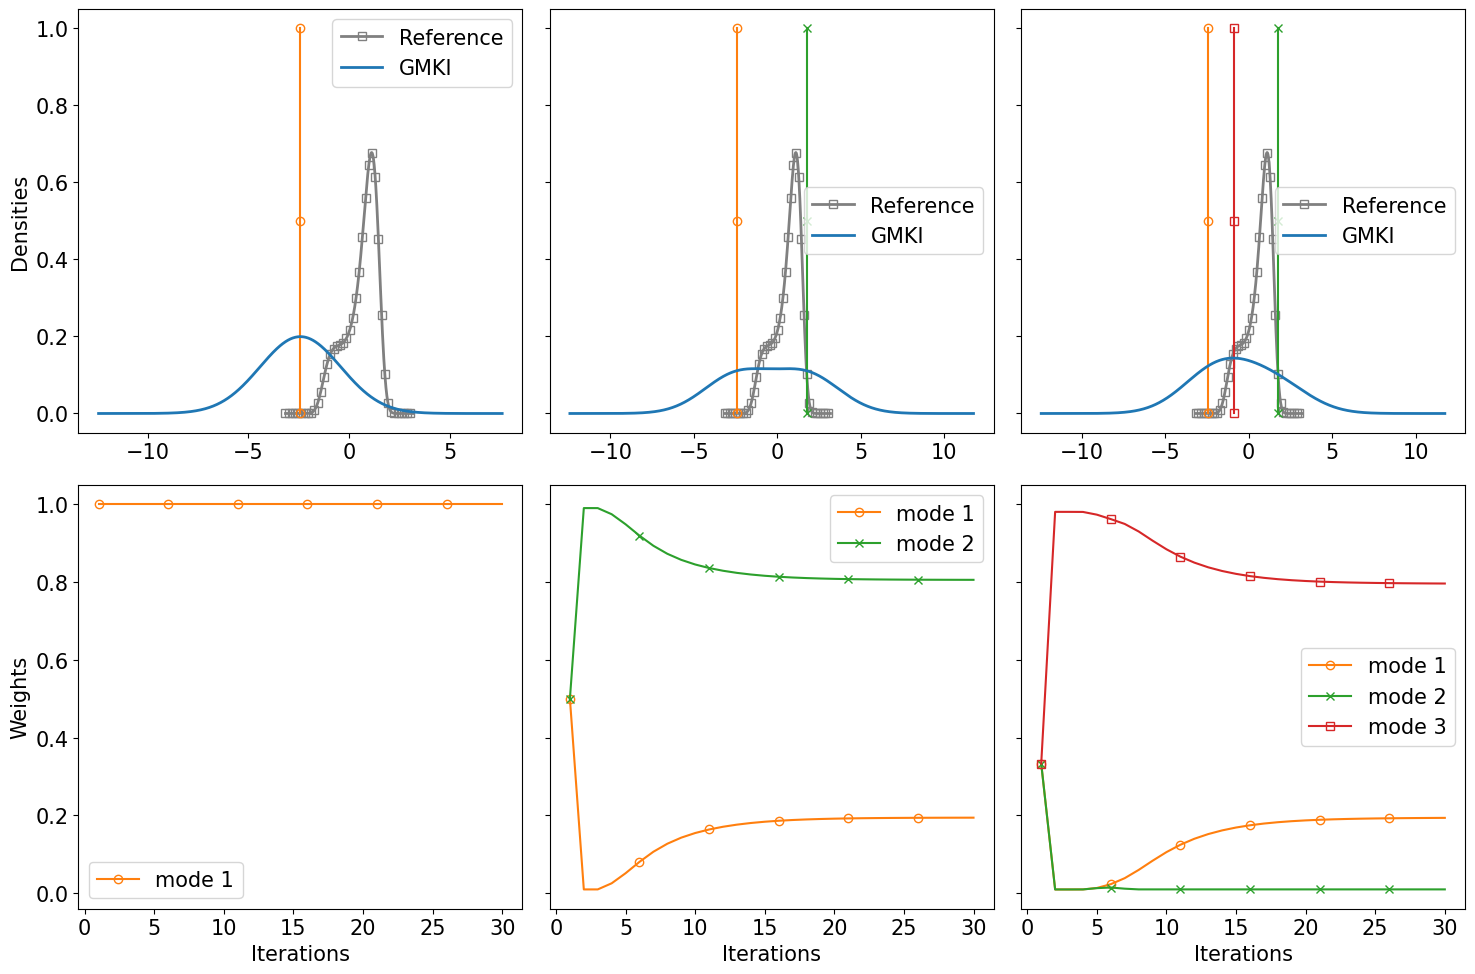

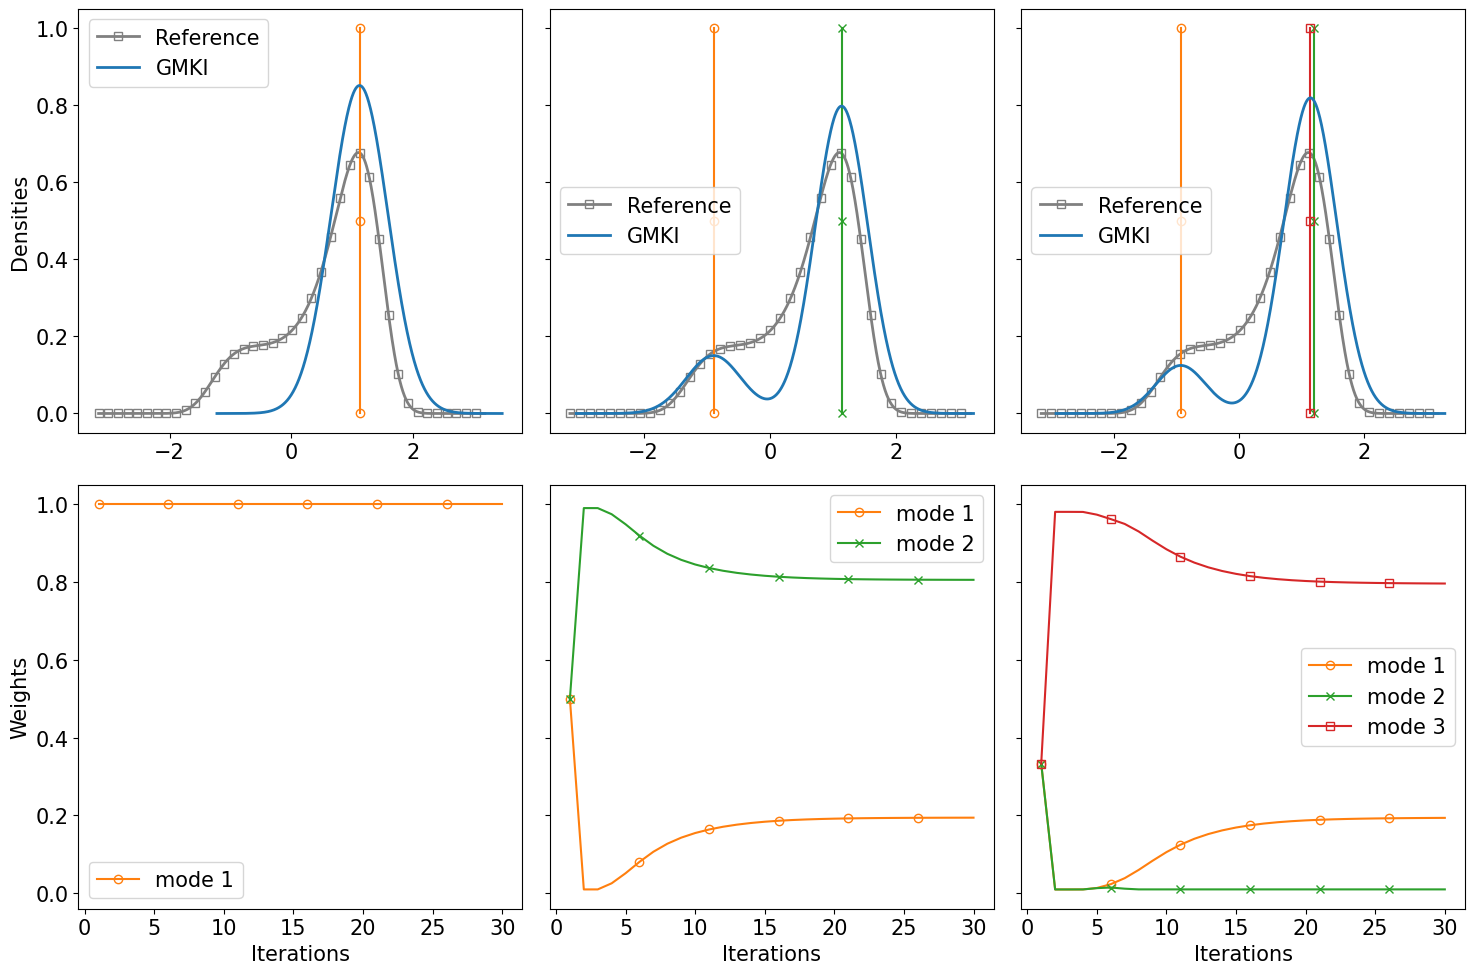

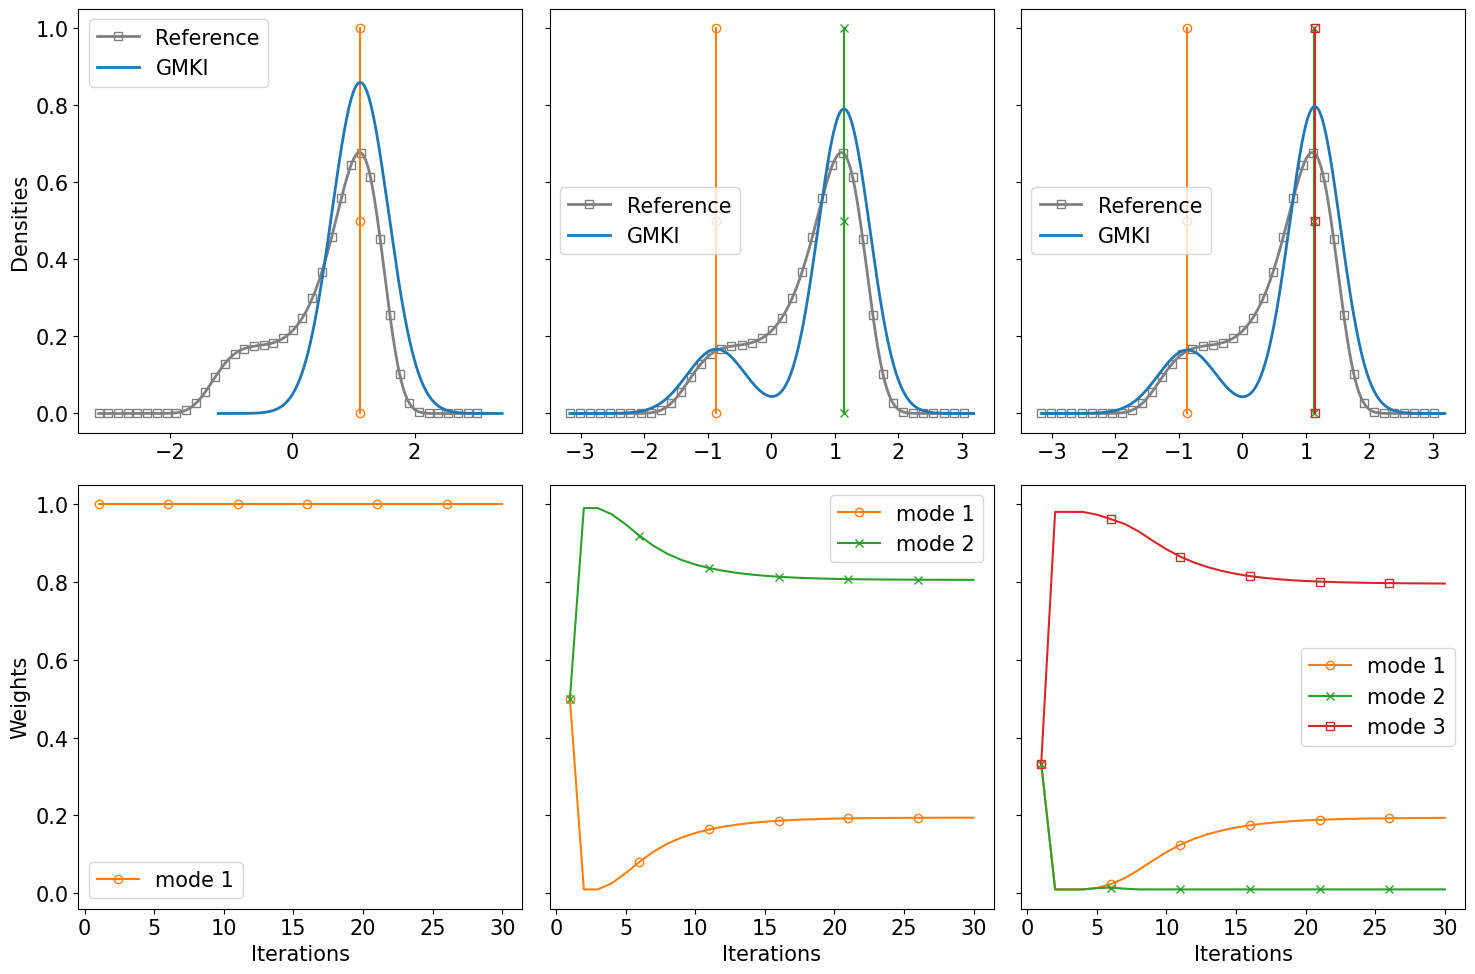

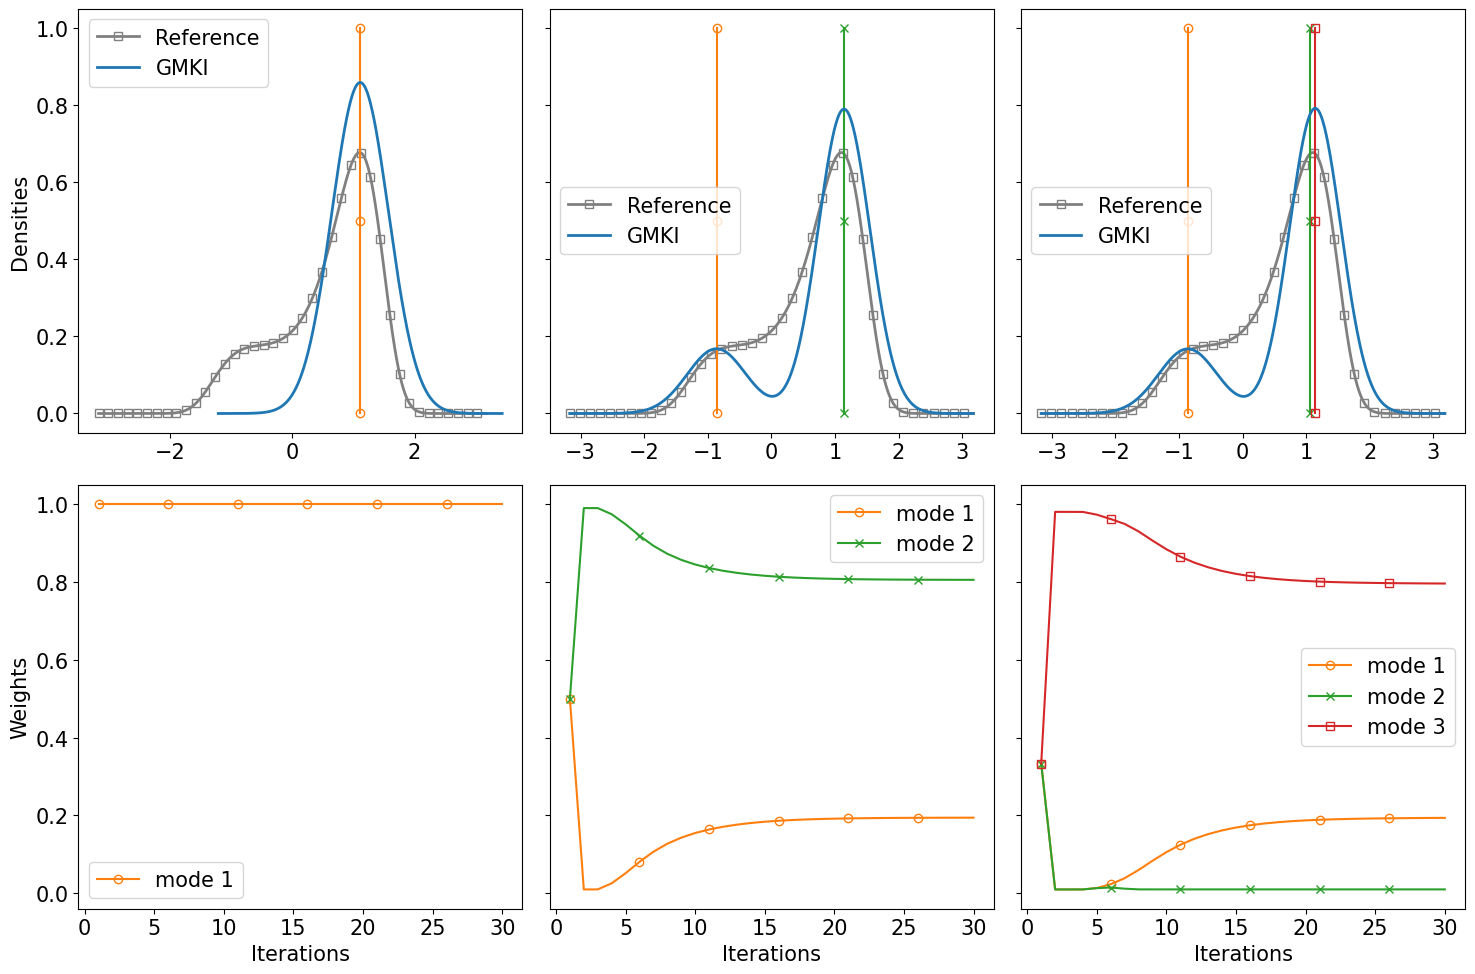

┌ Info: ("Run GMKI with ", 1, " θ0_mean = ", [-2.4283140297584804;;])
└ @ Main In[66]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:123
┌ Info: ("Run GMKI with ", 2, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095;;])
└ @ Main In[66]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:123
┌ Info: ("Run GMKI with ", 3, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095; -0.894645096090581;;])
└ @ Main In[66]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:123


In [69]:
Posterior_Plot(p2; θ_ref = 1.0, σ_η = 1.0, μ_0 = 3.0,  σ_0 = 2.0, Run_Fisher_Rao = false, plot_every = 5, mixture_power_sampling_method = mixture_power_sampling_method) 

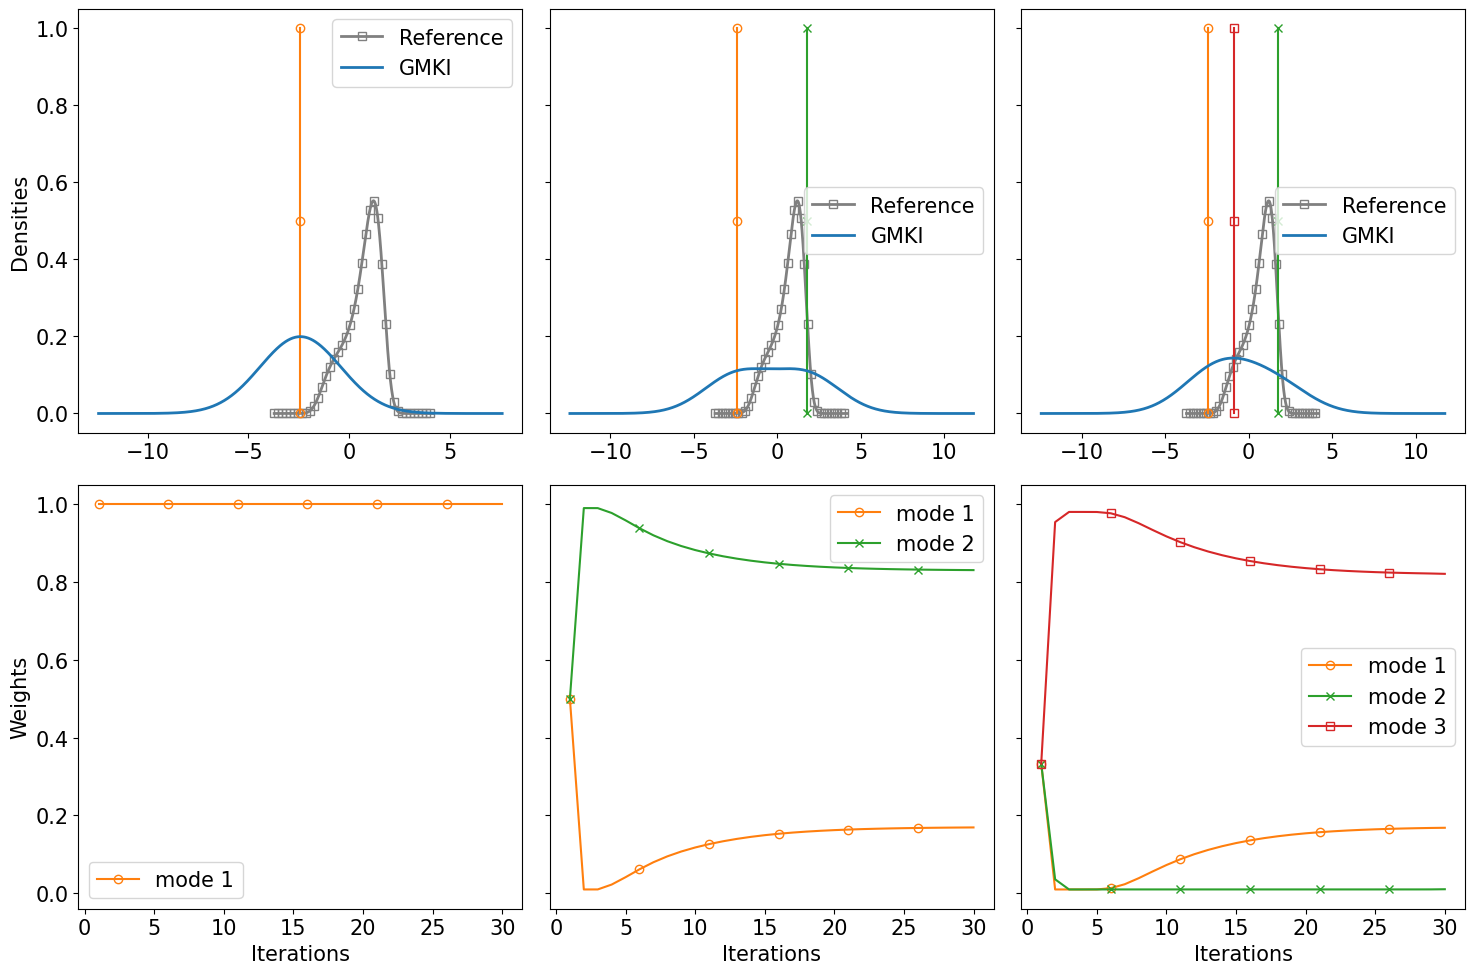

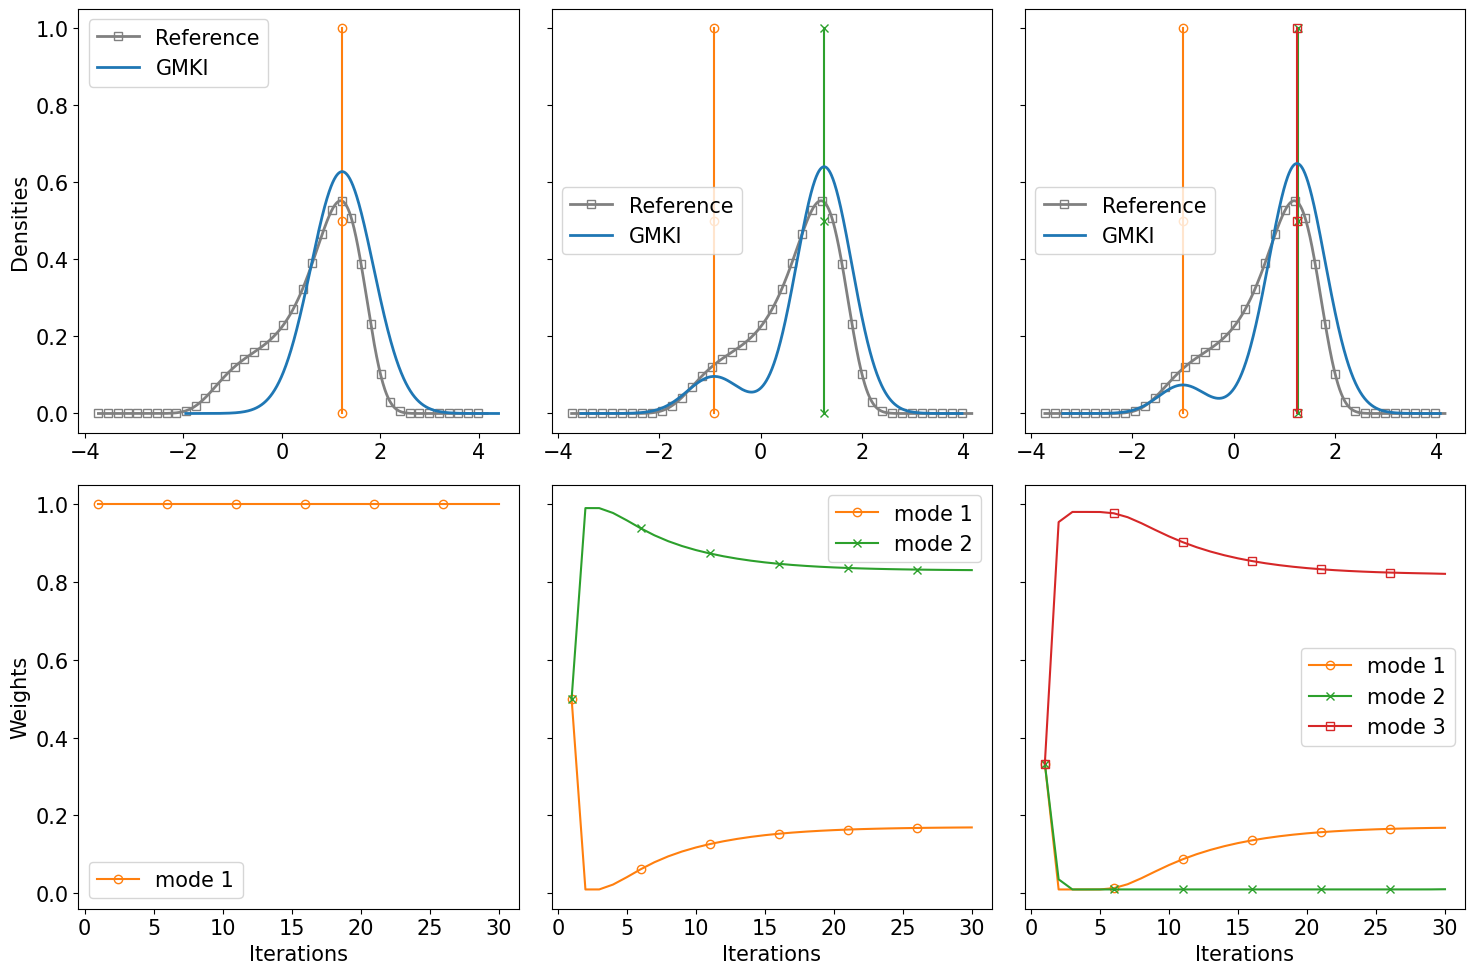

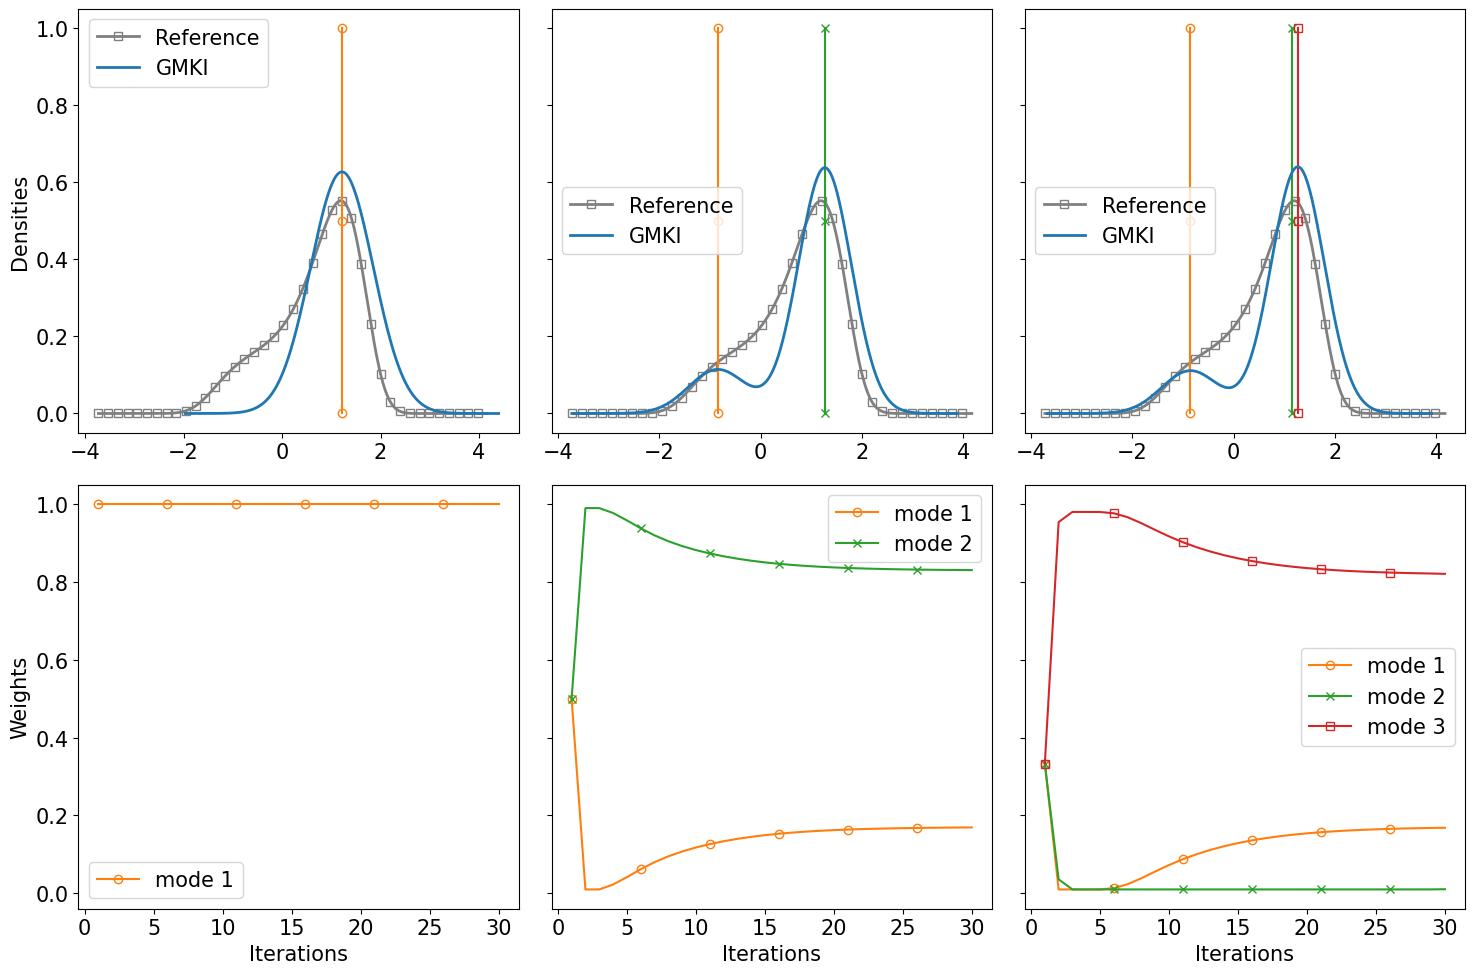

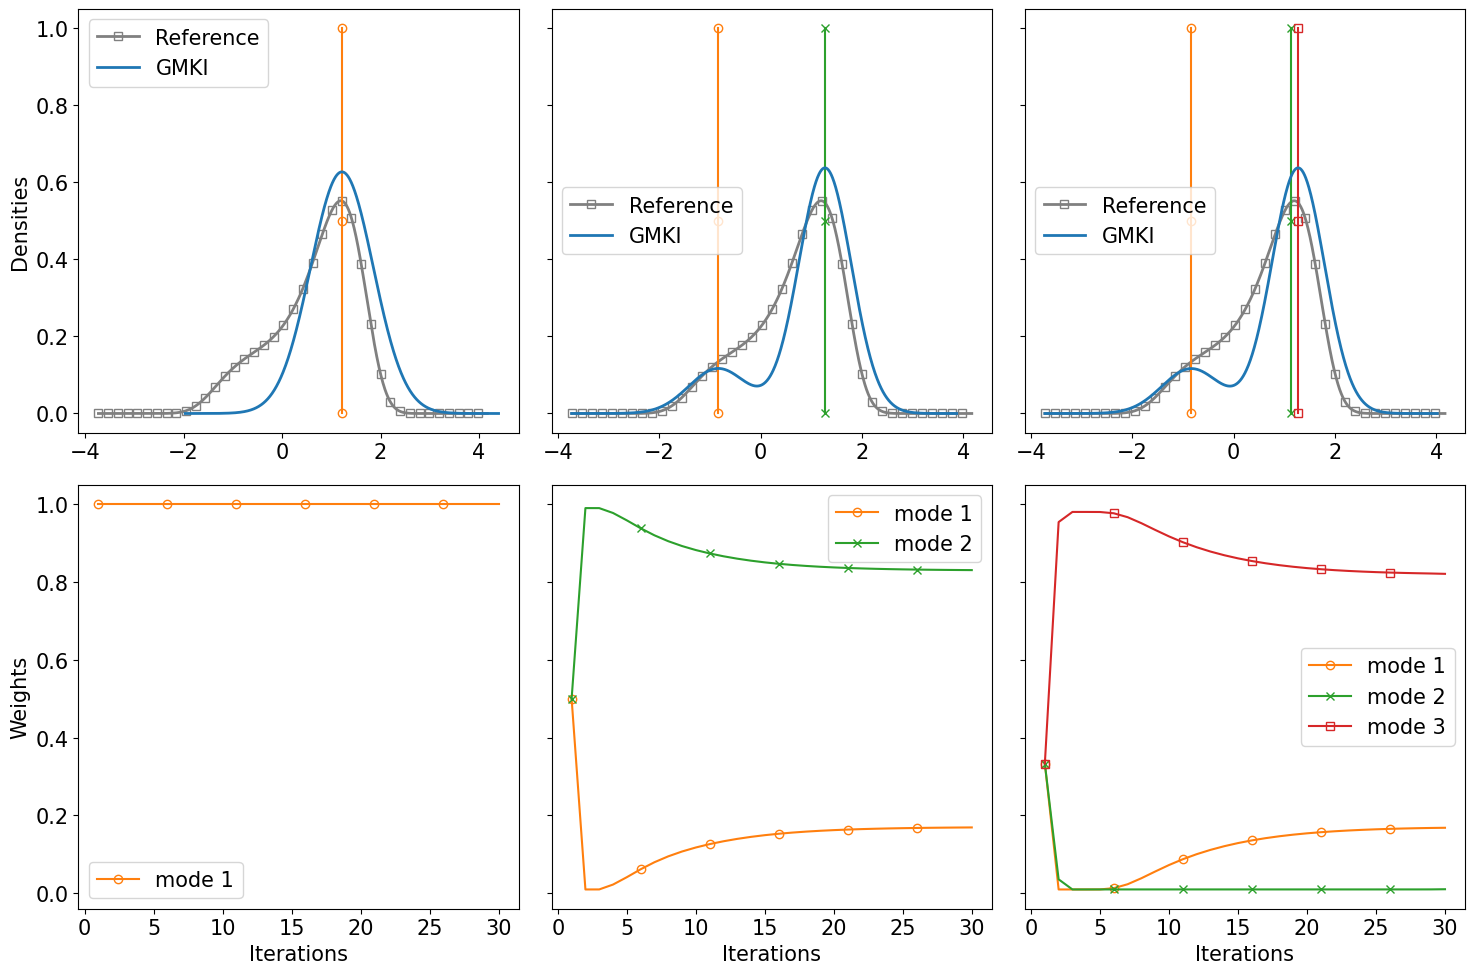

┌ Info: ("Run GMKI with ", 1, " θ0_mean = ", [-2.4283140297584804;;])
└ @ Main In[66]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:123
┌ Info: ("Run GMKI with ", 2, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095;;])
└ @ Main In[66]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:123
┌ Info: ("Run GMKI with ", 3, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095; -0.894645096090581;;])
└ @ Main In[66]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:123


In [70]:
Posterior_Plot(p2; θ_ref = 1.0, σ_η = 1.5, μ_0 = 3.0,  σ_0 = 2.0, Run_Fisher_Rao = false, plot_every = 5, mixture_power_sampling_method = mixture_power_sampling_method) 

# Benchmark with Gaussian Mixture Gradient Descent

In [43]:
function Posterior_Plot(forward::Function;  θ_ref = 1.0, σ_η = 1.0, μ_0 = 3.0,  σ_0 = 2.0,  plot_every = 1)

    
    N_y, N_θ = 1, 1
    s_param = Setup_Param(N_θ, N_y)
    y = forward(s_param, [θ_ref;])
    Σ_η = reshape([σ_η^2], (N_y, N_y))
    # prior distribution
    μ0,  Σ0   = [μ_0;], reshape([σ_0^2],  (N_θ, N_θ))
    
    
    logρ(θ) = log_bayesian_posterior(s_param, θ, forward, y, Σ_η, μ0, Σ0) 
    
    function gaussain_mixture_V(θ)
        V, ∇V, ∇²V = -logρ(θ), -ForwardDiff.gradient(logρ, θ), -ForwardDiff.hessian(logρ, θ)
        return V, ∇V, ∇²V
    end

    # compute posterior distribution by GMKI
    update_freq = 1
    
    Δt = 0.02
    N_iter = 200
    T = N_iter * Δt
    gmgdobjs = [] 
    for N_modes = 1:3
        
        θ0_w  = fill(1.0, N_modes)/N_modes
        θ0_mean, θθ0_cov  = zeros(N_modes, N_θ), zeros(N_modes, N_θ, N_θ)

        Random.seed!(111);
        for m = 1:N_modes
            θ0_mean[m, :]    .= rand(Normal(0, σ_0), N_θ)
            θθ0_cov[m, :, :] .= Array(Diagonal(fill(σ_0^2, N_θ)))
        end
        @info "Run GMGD with ", N_modes, " θ0_mean = ", θ0_mean
        
        metric = "Fisher-Rao"
        update_covariance = true
        expectation_method = "unscented_transform"
        N_ens = 1
        gmgdobj = GMGD_Run(
            gaussain_mixture_V, 
            N_iter,
            T,
            metric,
            update_covariance, 
            θ0_w, θ0_mean, θθ0_cov,
            expectation_method,
            N_ens)
        
        push!(gmgdobjs, gmgdobj) 
    
    end


    
        
    Nx = 1000
    θ_min = minimum(gmgdobjs[end].θ_mean[end][:,1] .- 5sqrt.(gmgdobjs[end].θθ_cov[end][:,1,1]))
    θ_max = maximum(gmgdobjs[end].θ_mean[end][:,1] .+ 5sqrt.(gmgdobjs[end].θθ_cov[end][:,1,1]))

    # Plot reference
    xx_ref = Array(LinRange(θ_min, θ_max, 1000))
    yy_ref = copy(xx_ref)
    for i = 1:length(xx_ref)
        y_pred = forward(s_param, [xx_ref[i];])[1]
        yy_ref[i] = exp( - 0.5*(y_pred - y[1])^2/σ_η^2  - 0.5*(xx_ref[i] - μ_0)^2/σ_0^2 )
    end
    yy_ref .= yy_ref / ( sum(yy_ref)*(xx_ref[2] - xx_ref[1]) )
           
    
    
    # visualization 
    plot_every = 10
    linestyles = ["o"; "x"; "s"]
    # Visualize different iterations
    for iter  = [1:plot_every:N_iter; N_iter]
        nrows, ncols = 2, 3
        fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=false, sharey="row", figsize=(15,10))
        
        
        # plot UKI results 
        for N_modes = 1:3
            
            # Plot reference
            ax[1, N_modes].plot(xx_ref, yy_ref, "-s", label="Reference", color="grey", linewidth=2, fillstyle="none", markevery=25)
           
            
            
            
            
            Nx = 1000
            xxs, zzs = zeros(N_modes, Nx), zeros(N_modes, Nx)
            θ_min = minimum(gmgdobjs[N_modes].θ_mean[iter][:,1] .- 5sqrt.(gmgdobjs[N_modes].θθ_cov[iter][:,1,1]))
            θ_max = maximum(gmgdobjs[N_modes].θ_mean[iter][:,1] .+ 5sqrt.(gmgdobjs[N_modes].θθ_cov[iter][:,1,1]))            
            
            
            for i =1:N_modes
                xxs[i, :], zzs[i, :] = Gaussian_1d(gmgdobjs[N_modes].θ_mean[iter][i,1], gmgdobjs[N_modes].θθ_cov[iter][i,1,1], Nx, θ_min, θ_max)
                zzs[i, :] *= exp(gmgdobjs[N_modes].logθ_w[iter][i])
                
                ax[1, N_modes].plot(fill(gmgdobjs[N_modes].θ_mean[iter][i,1], 11), LinRange(0,1,11), marker=linestyles[i], fillstyle="none", markevery=5, color="C"*string(i))


                # ax[1, N_modes].plot(xxs[i,:], zzs[i,:], marker= linestyles[i], linestyle=":", color="C"*string(i), fillstyle="none", markevery=100, label="modal "*string(i))
            end
            ax[1, N_modes].plot(xxs[1,:], sum(zzs, dims=1)', linestyle="-", color="C0", fillstyle="none", markevery=100, label="GMKI", linewidth=2)
        


            ax[1, N_modes].legend()
            
            
            θ_w = exp.(hcat(gmgdobjs[N_modes].logθ_w...))
            for i =1:N_modes
                ax[2, N_modes].plot(Array(1:N_iter), θ_w[i, 1:N_iter], marker=linestyles[i], color = "C"*string(i), fillstyle="none", markevery=5, label= "mode "*string(i))
            end
            ax[2, N_modes].legend()
            ax[2, N_modes].set_xlabel("Iterations")
        end
        ax[1, 1].set_ylabel("Densities")
        ax[2, 1].set_ylabel("Weights")
        
        fig.tight_layout()
        fig.savefig("GMGD-1D-density-"*string(σ_η)*"-"*string(iter)*".pdf")
    end
    
    
    
end

"continuous-time"

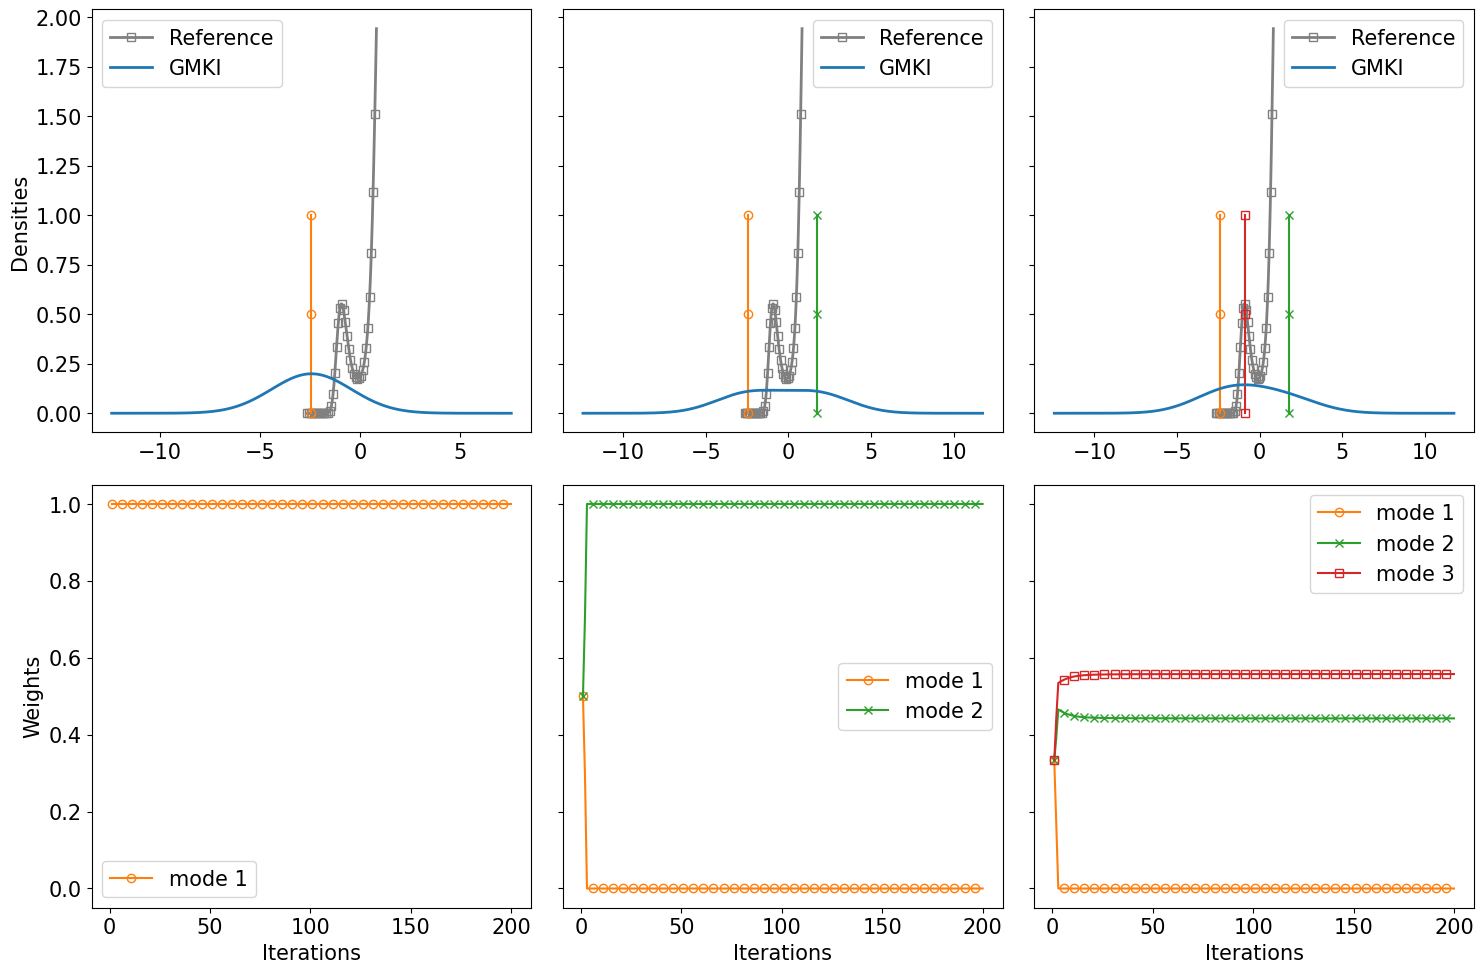

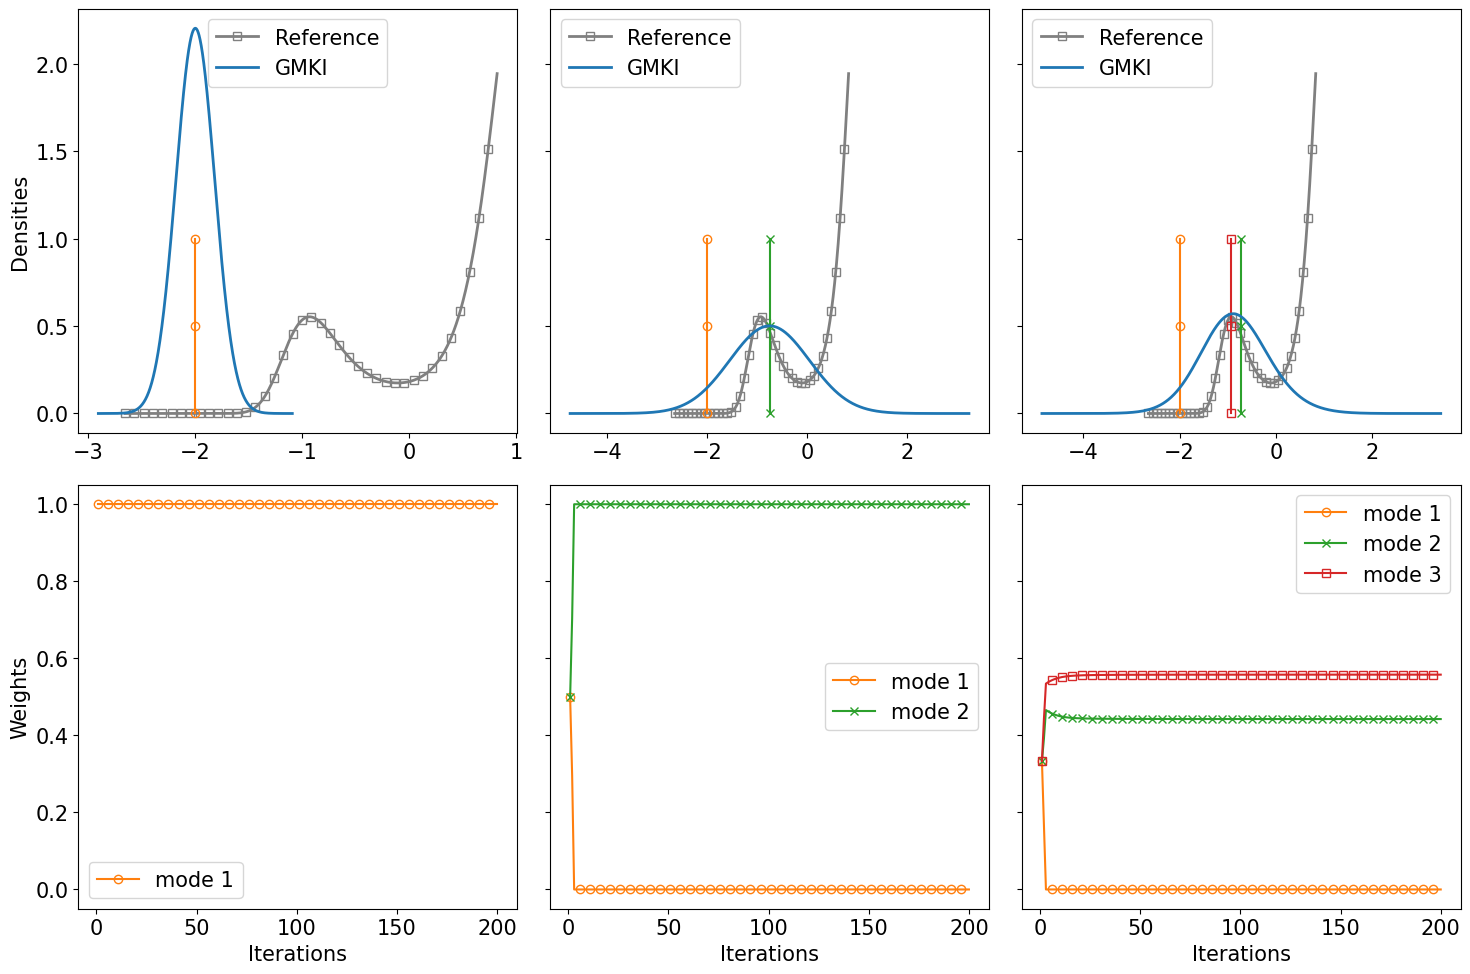

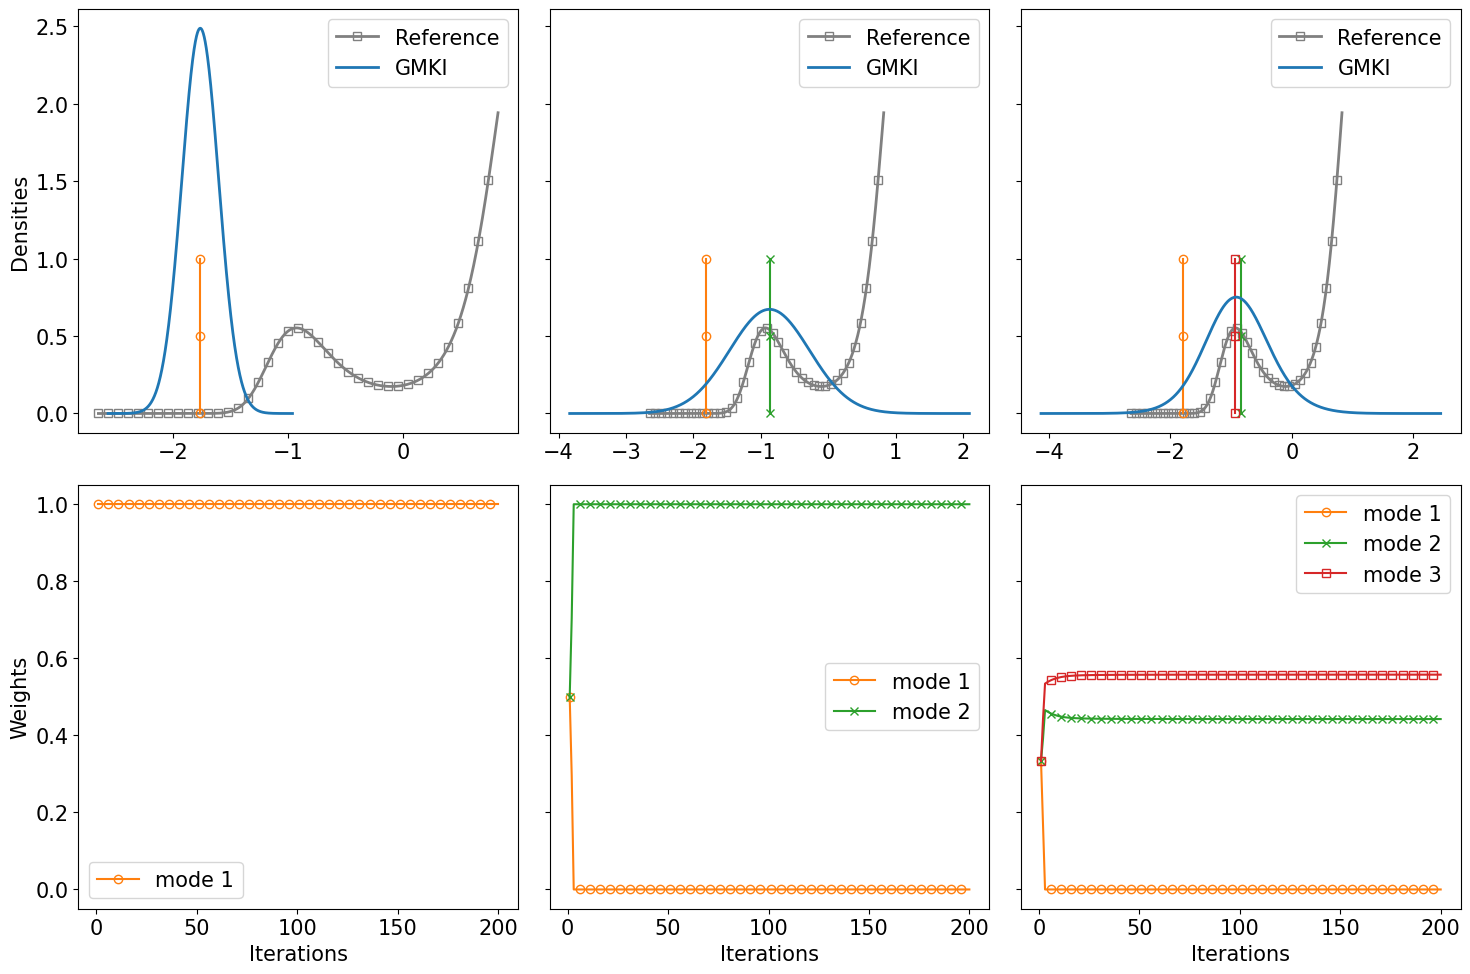

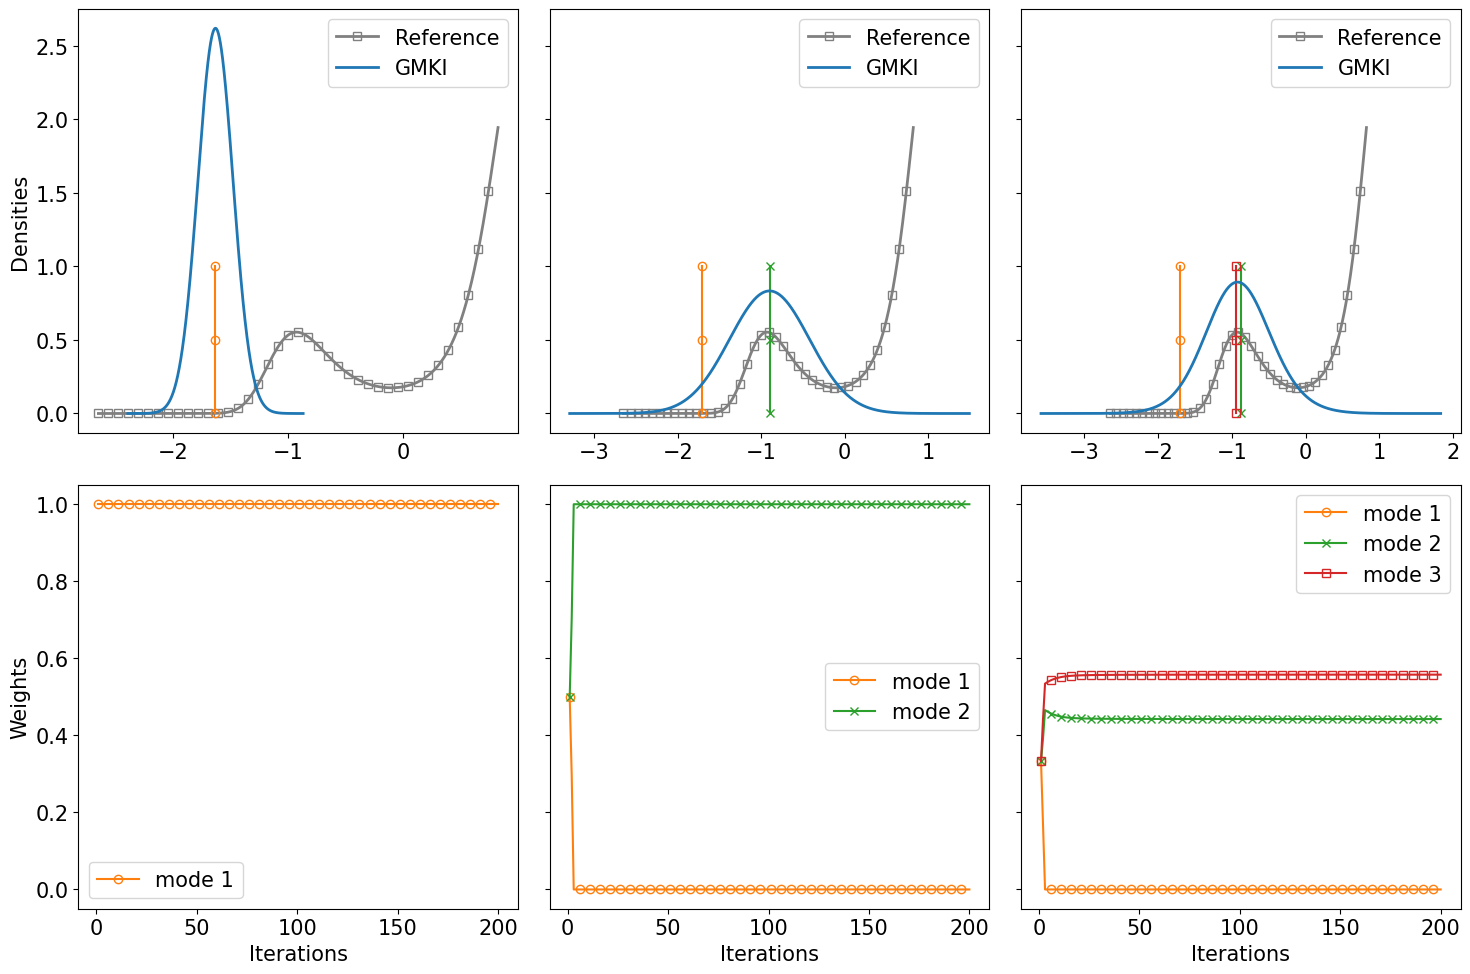

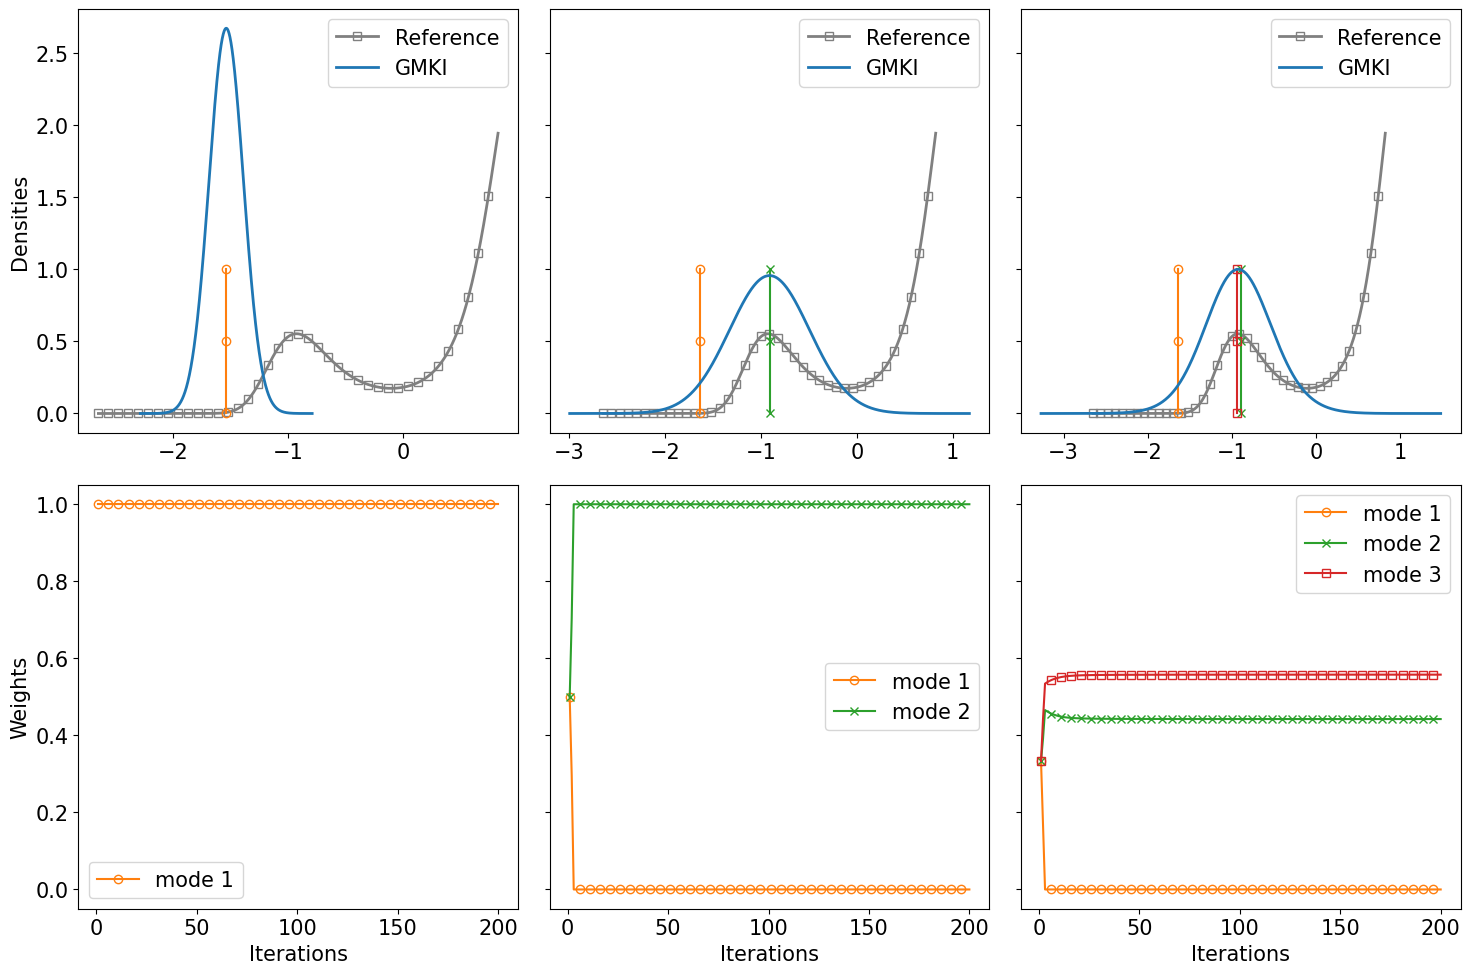

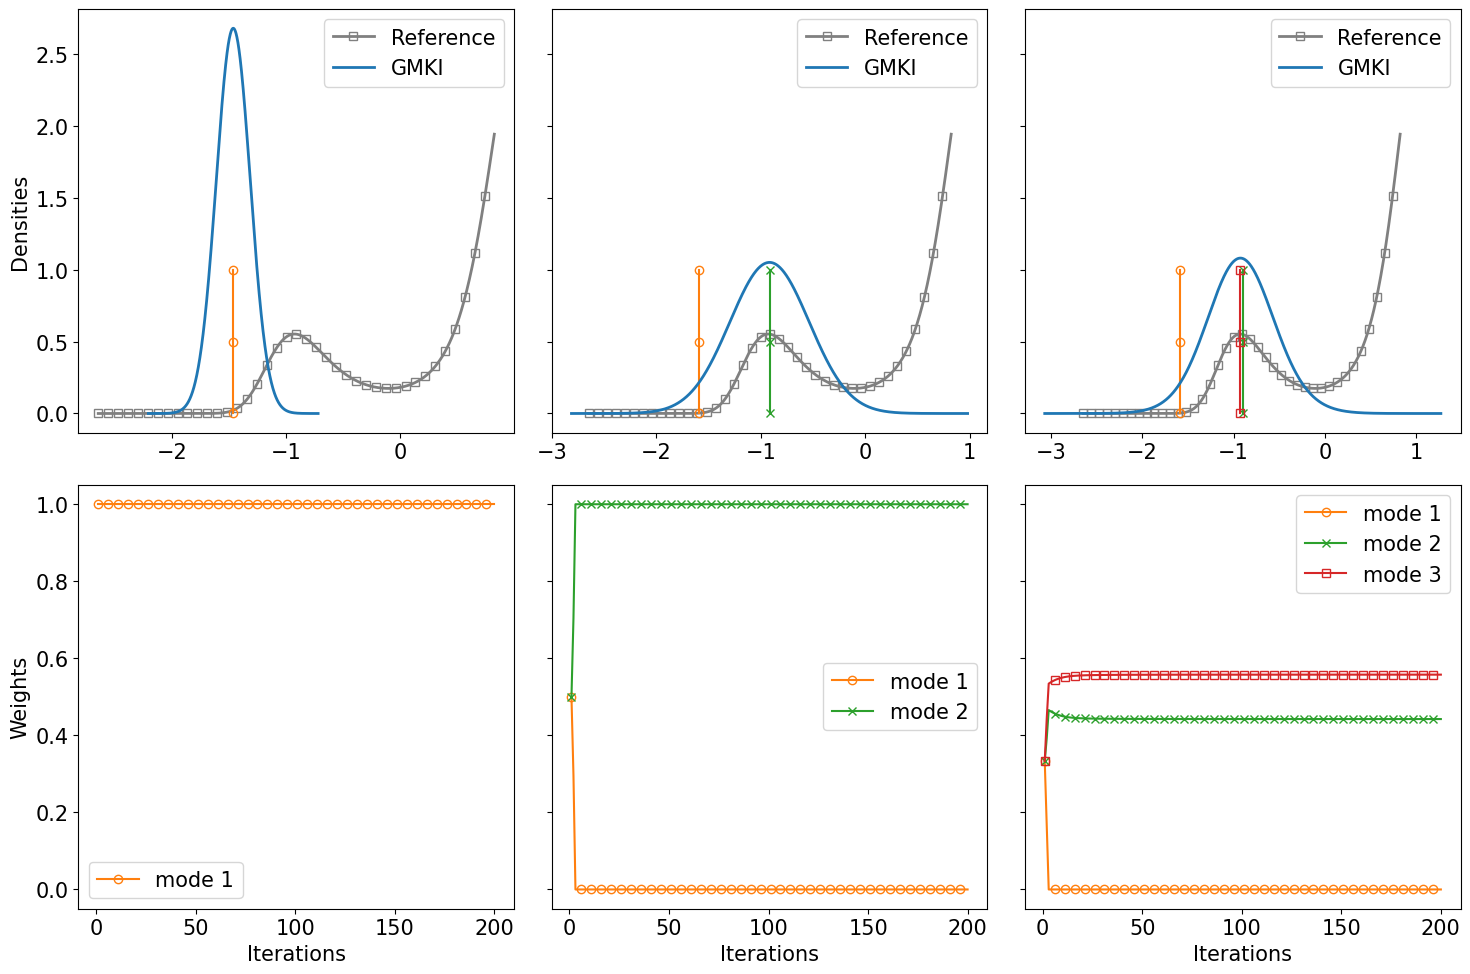

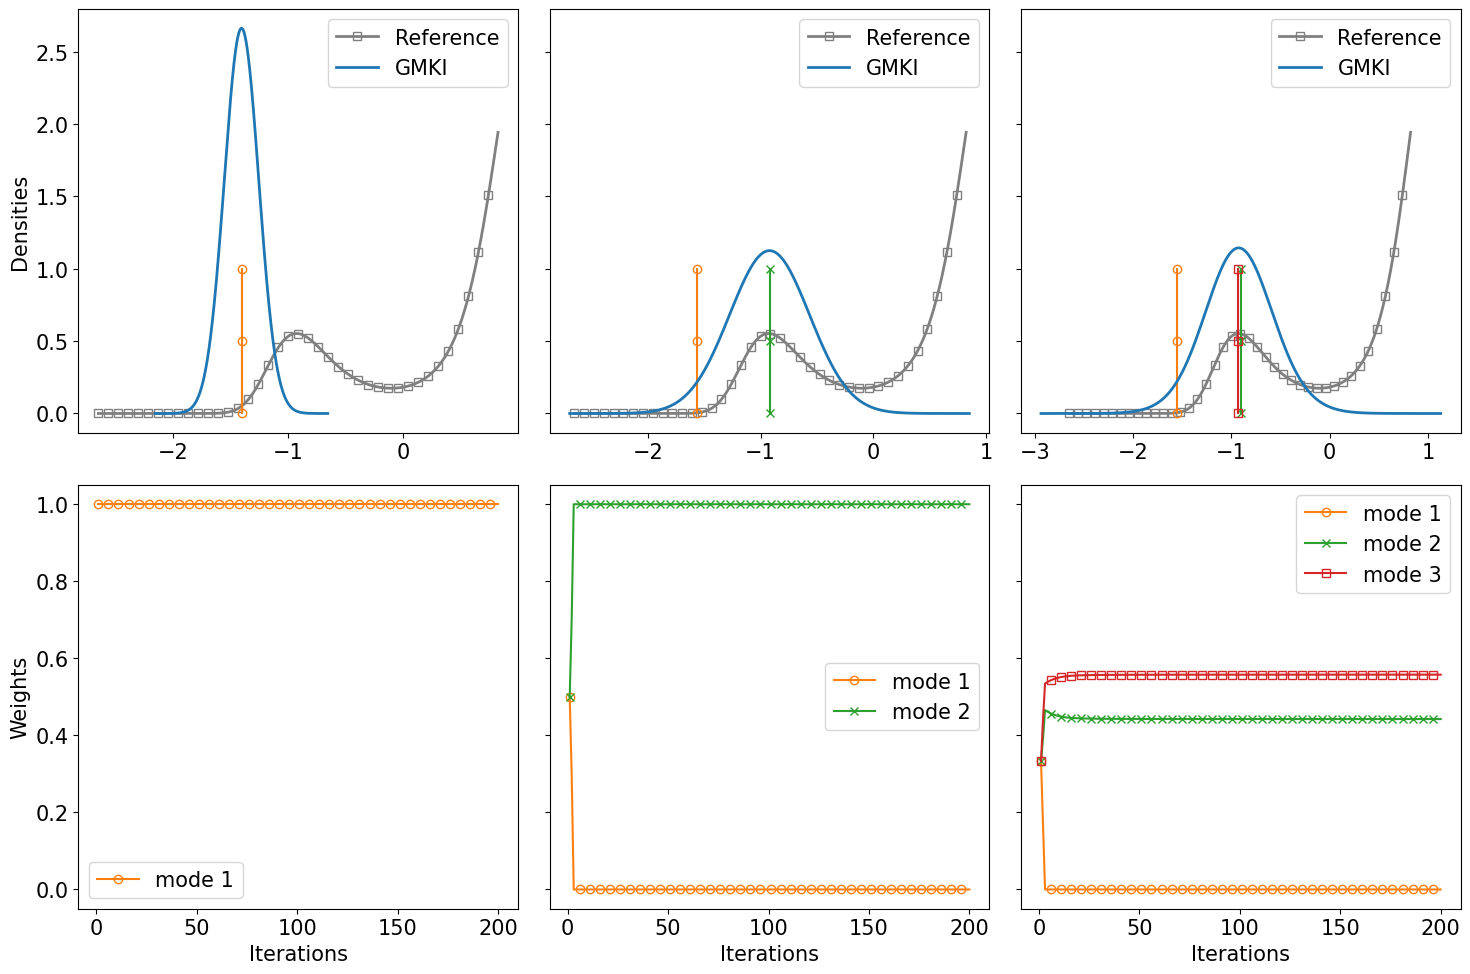

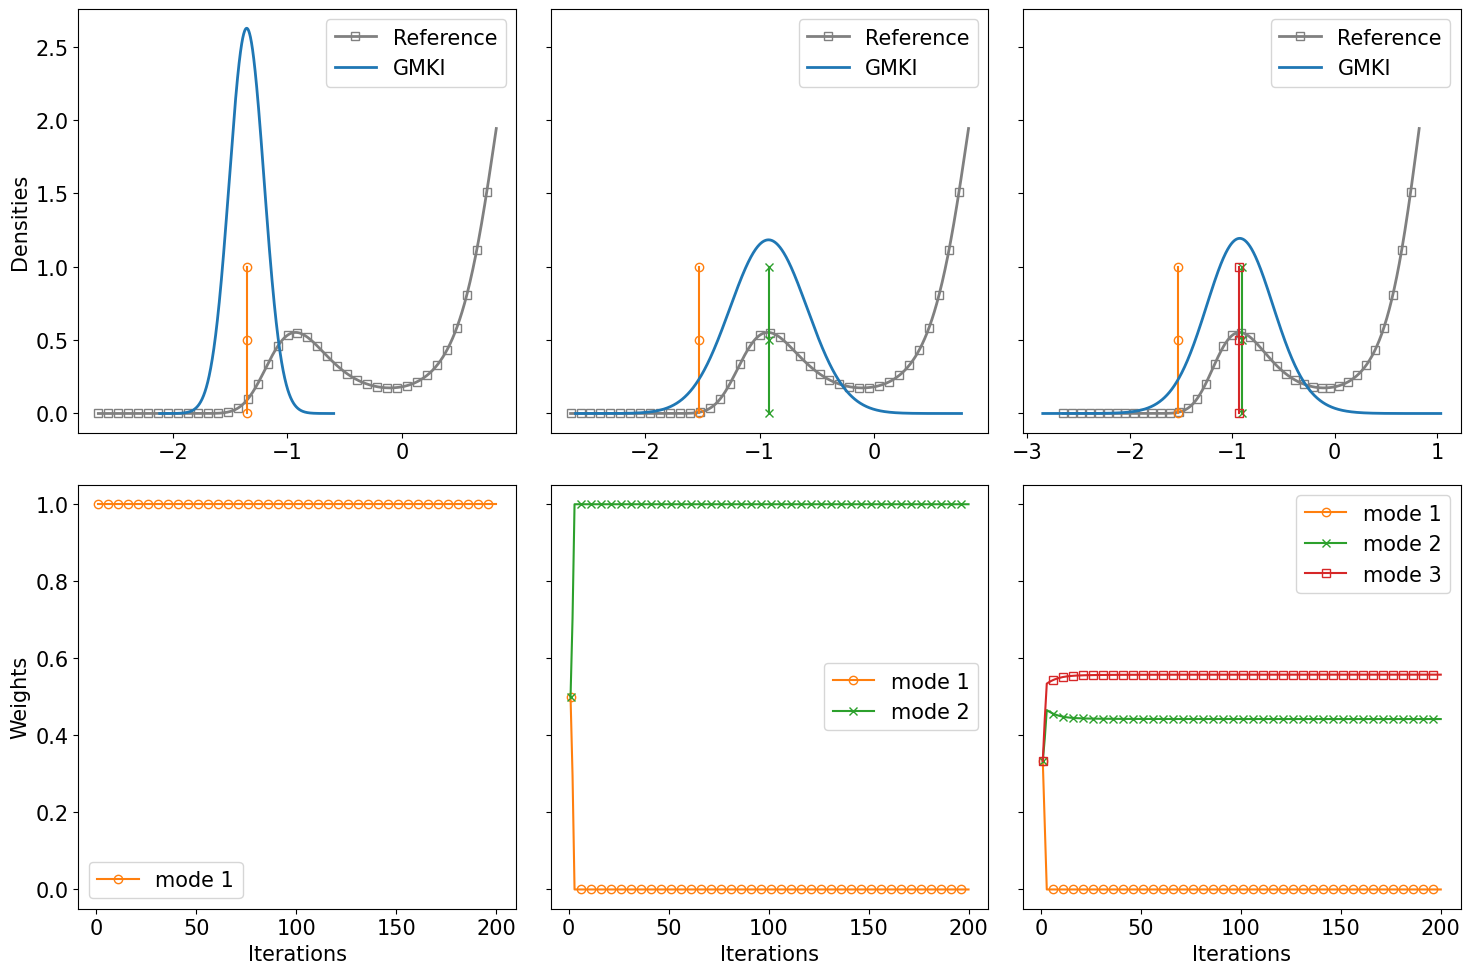

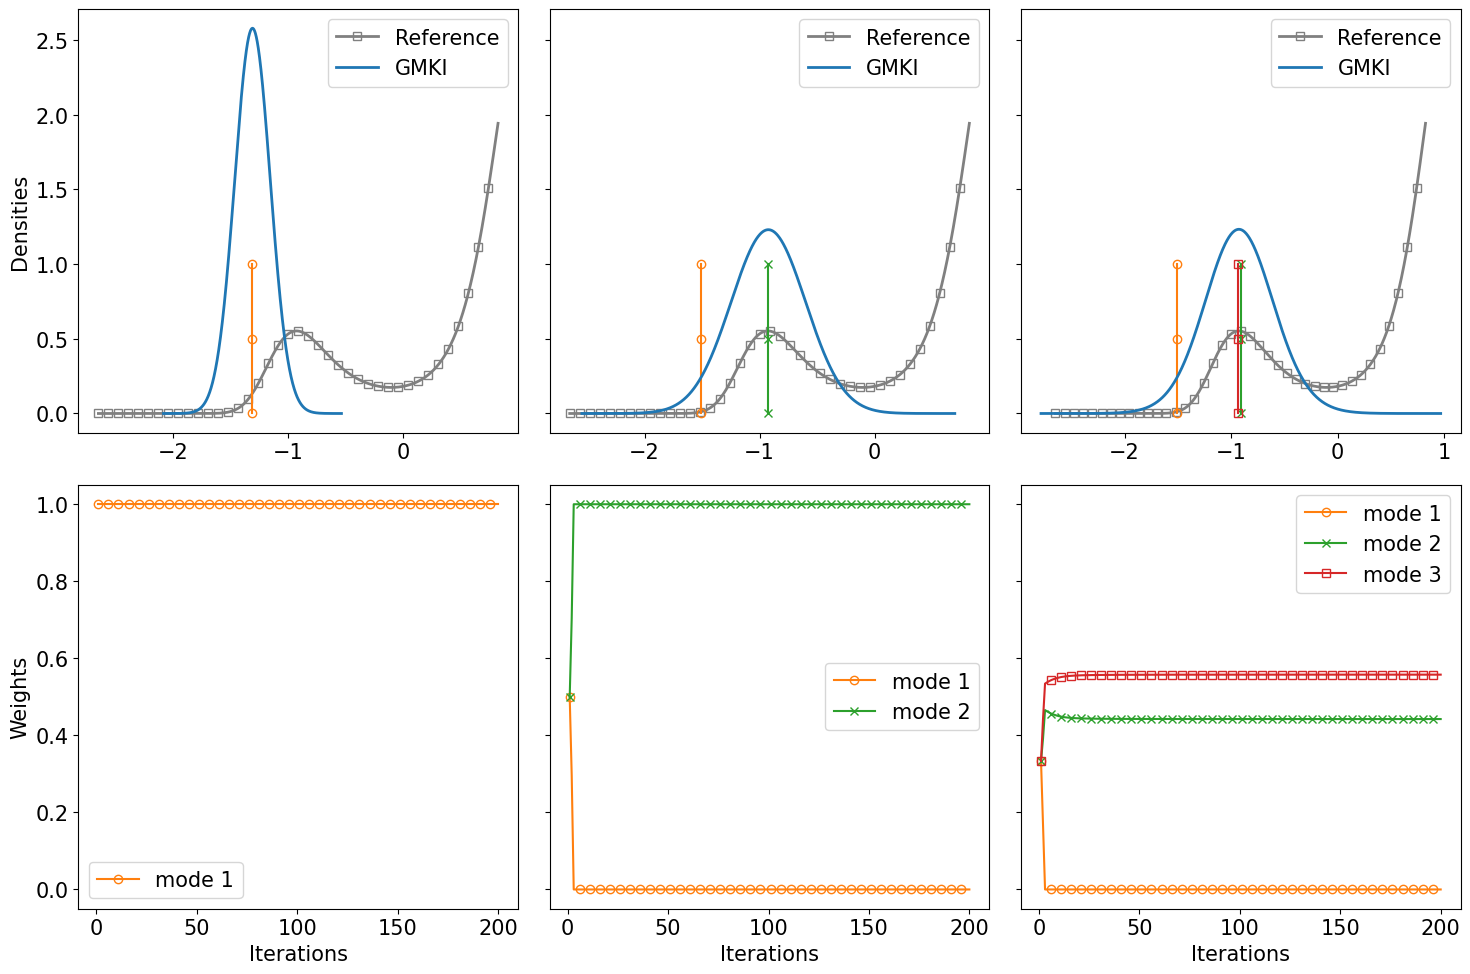

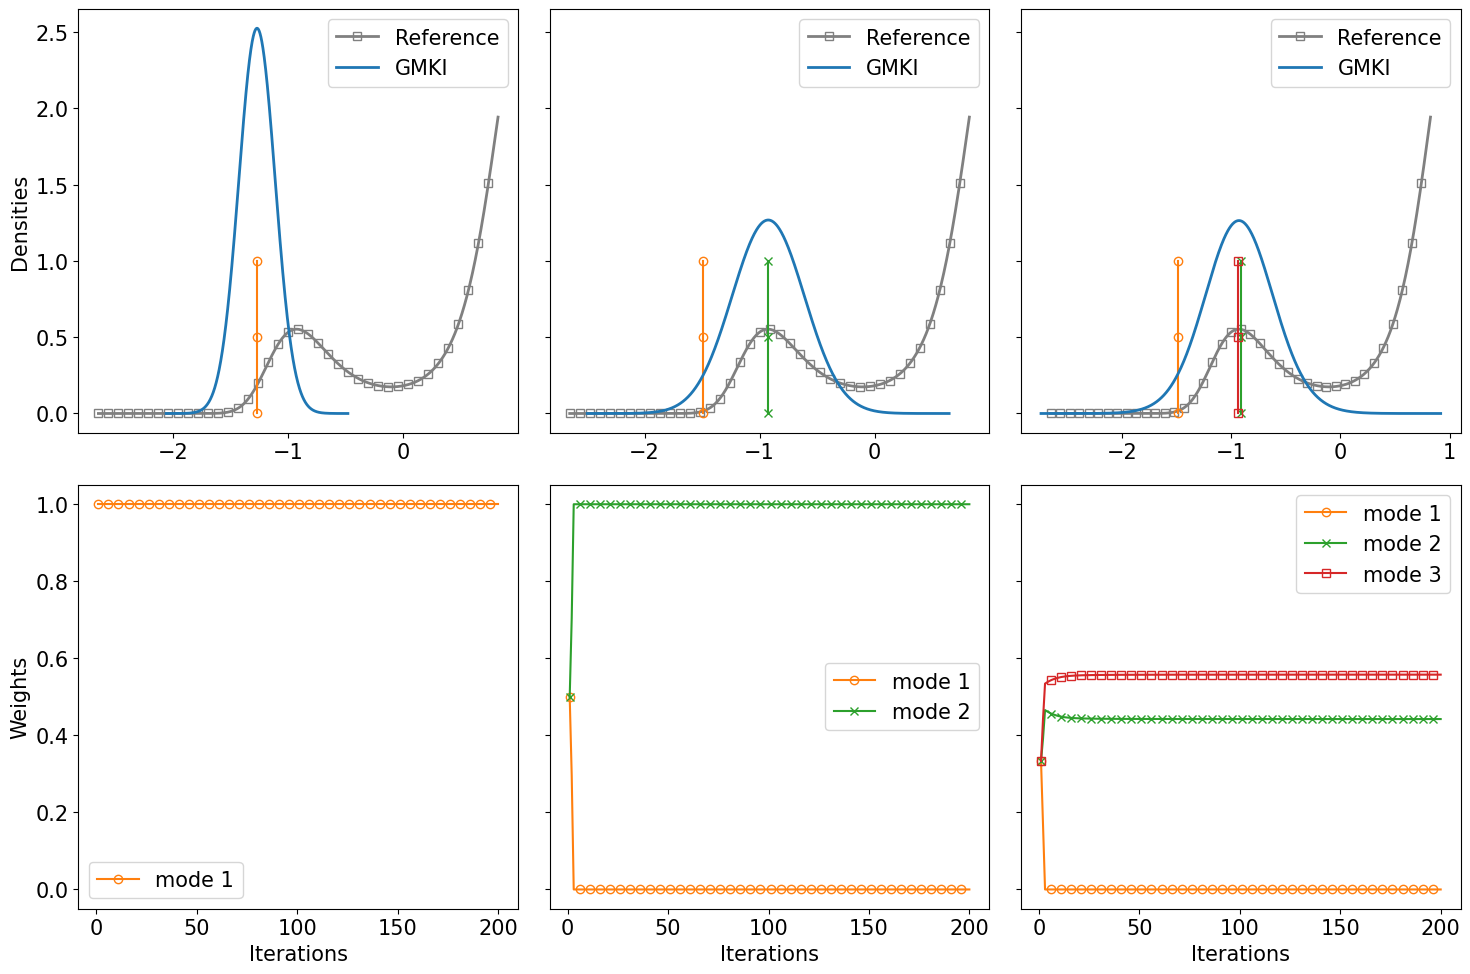

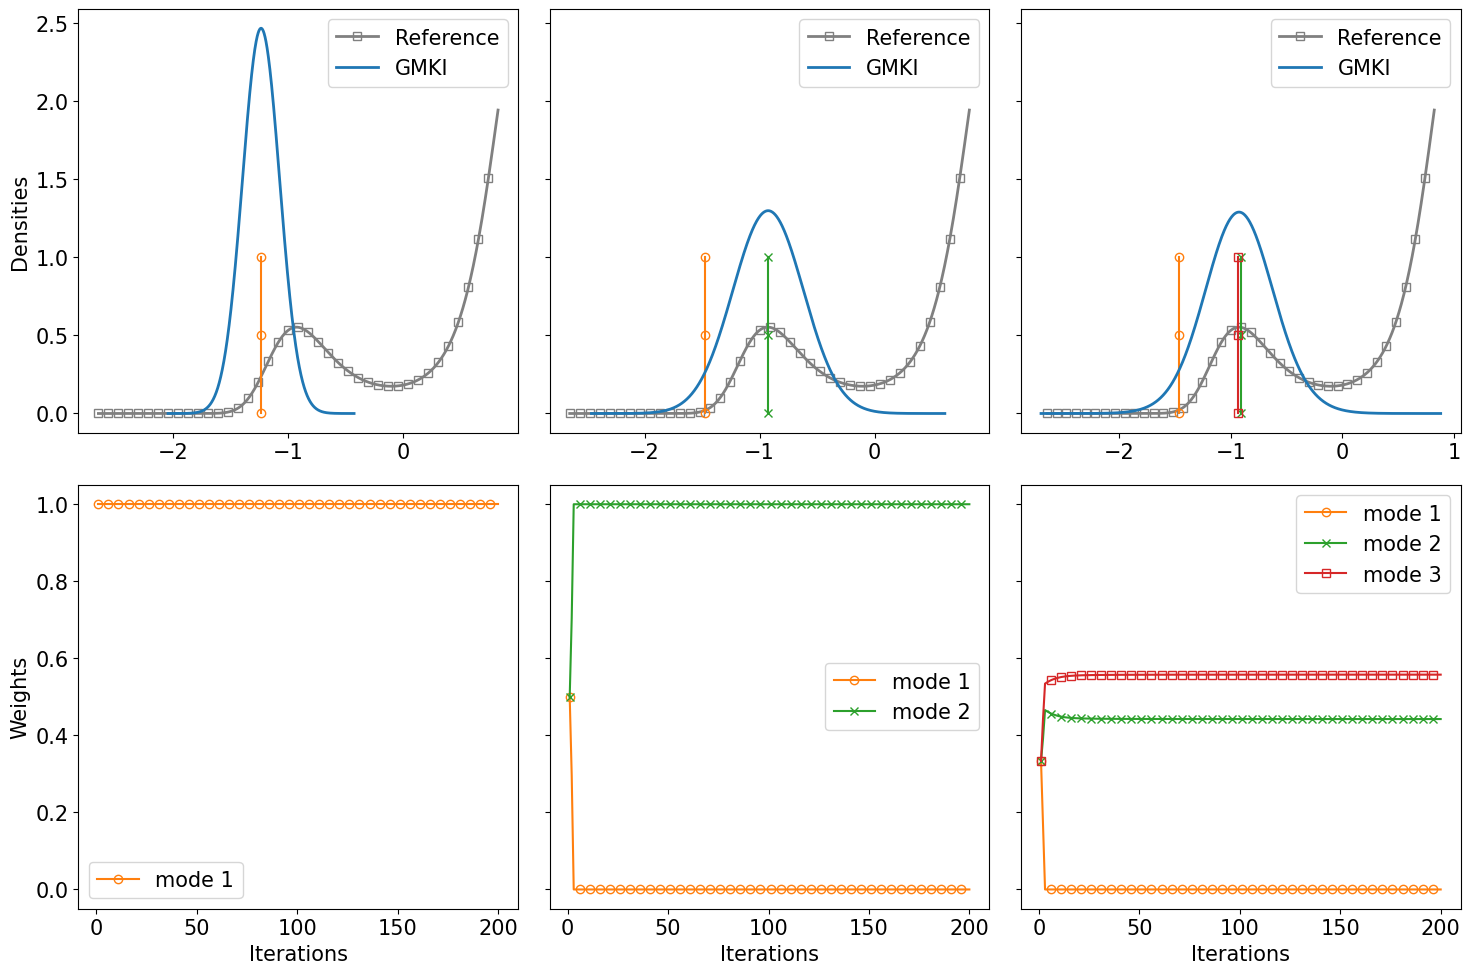

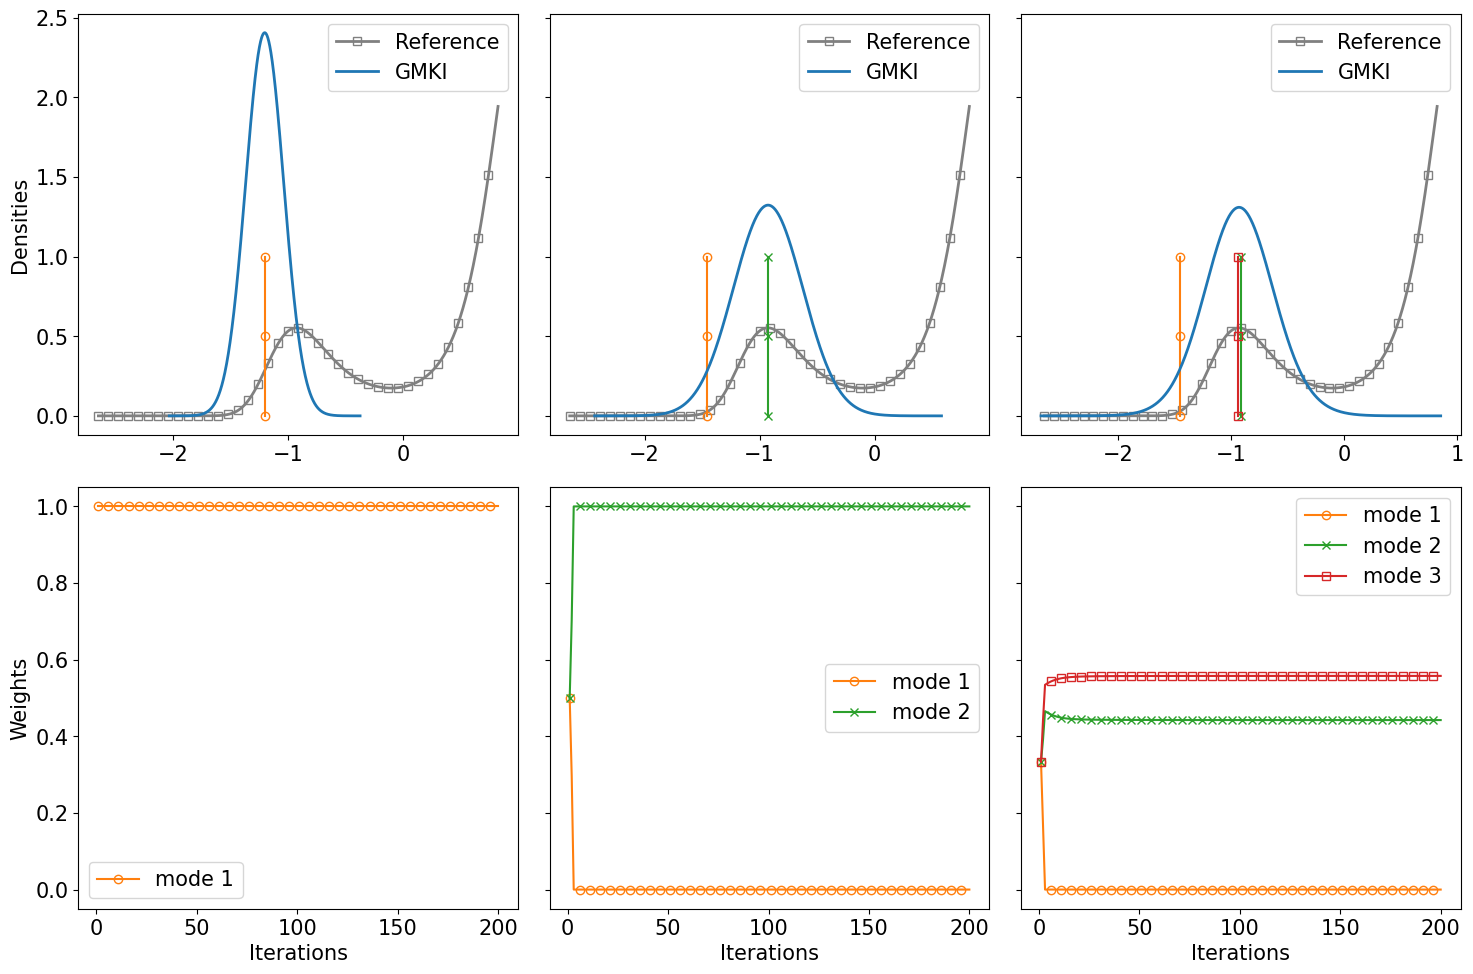

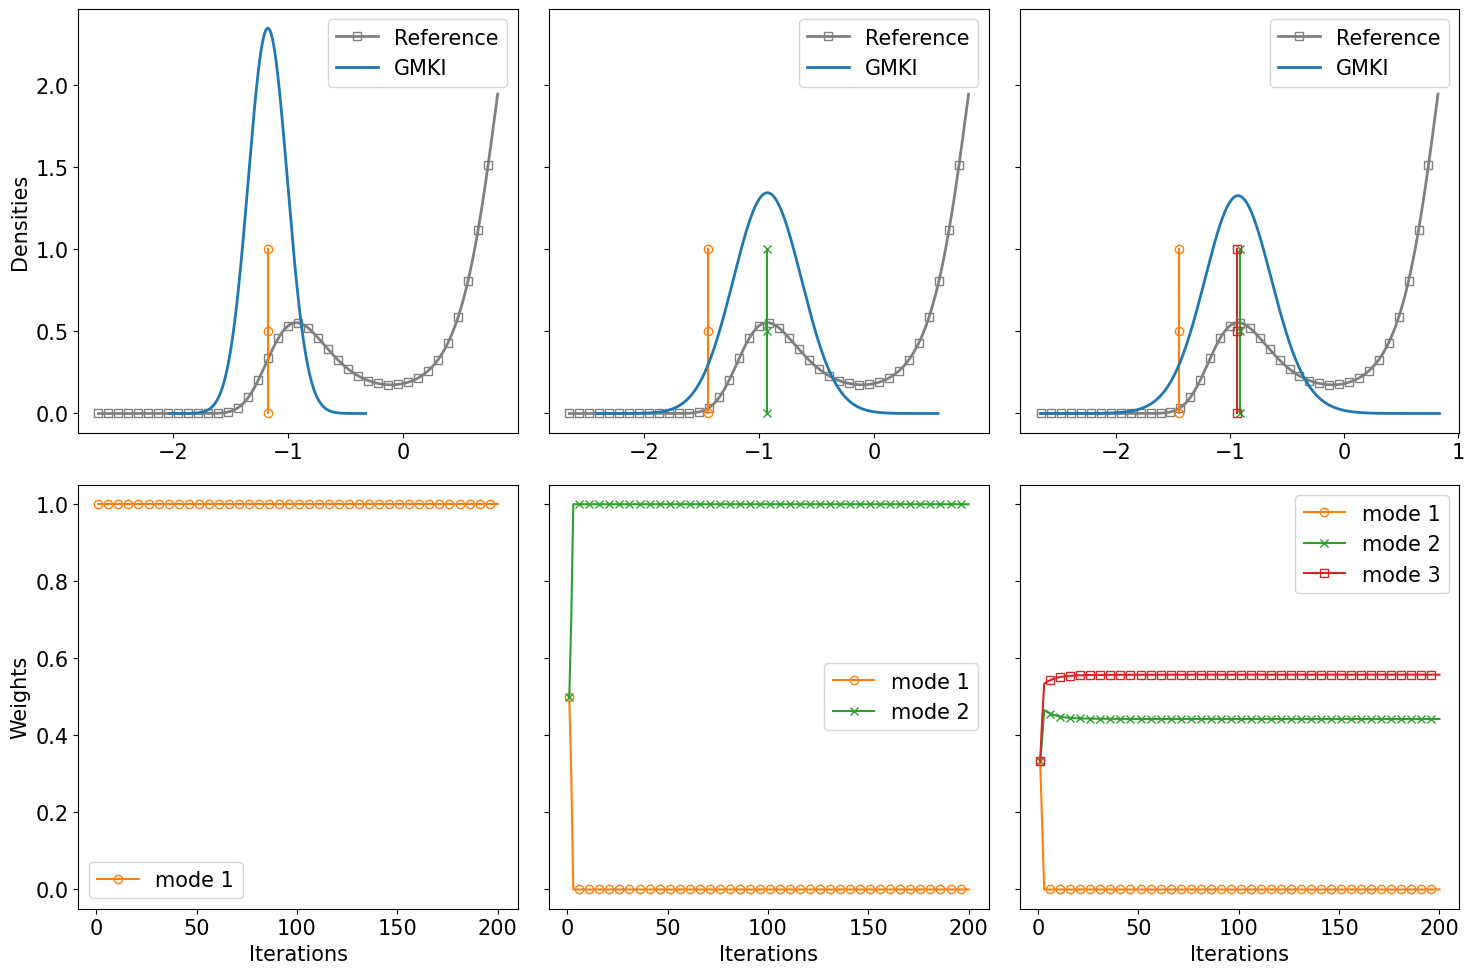

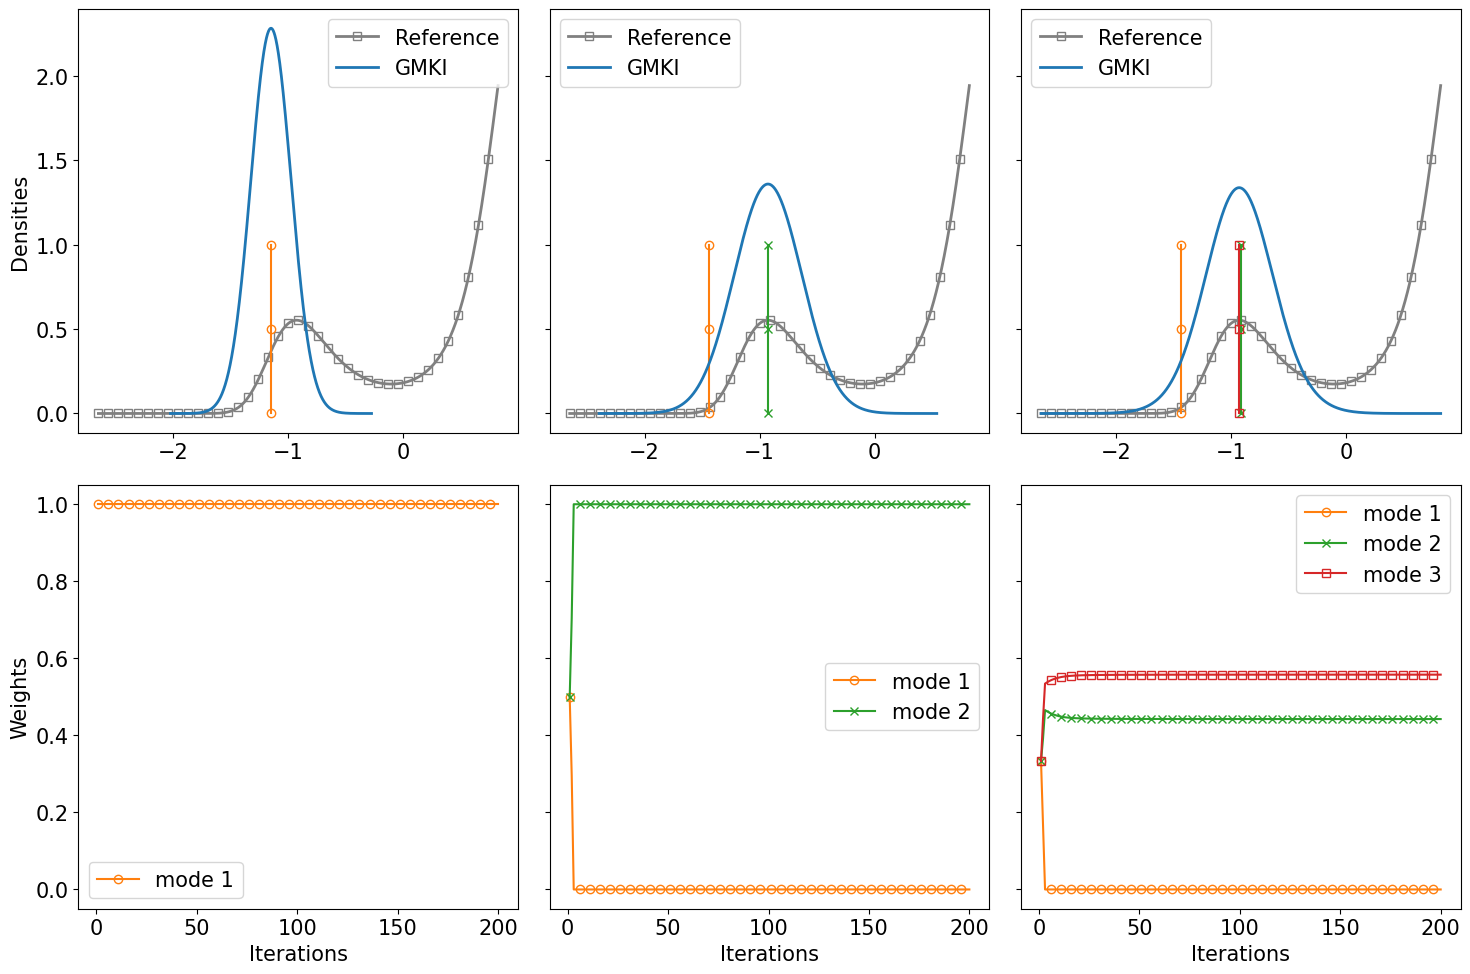

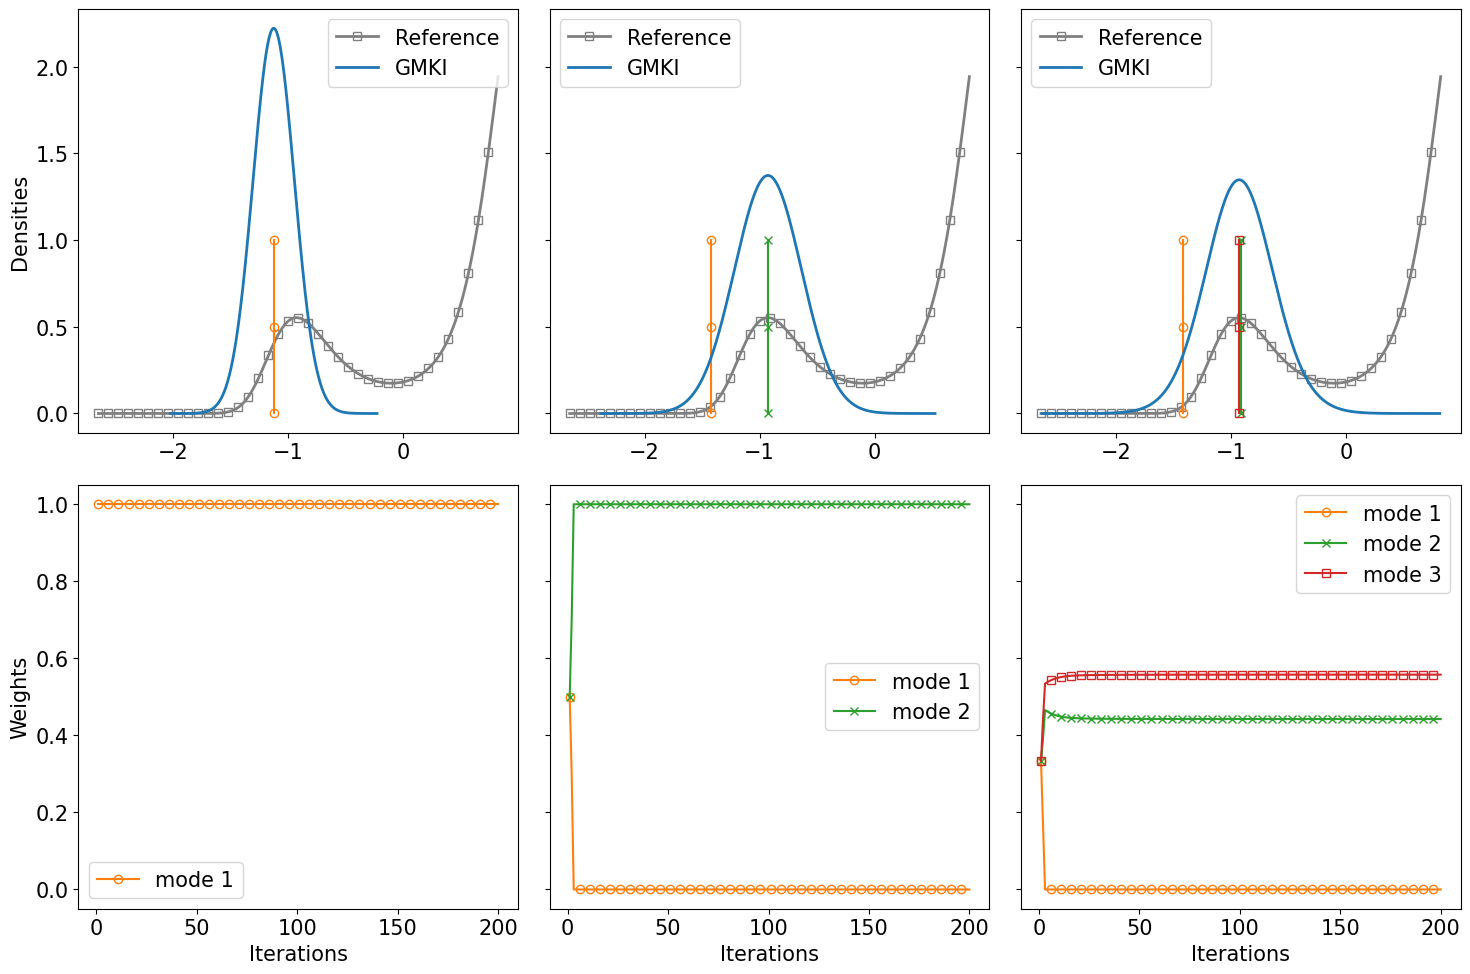

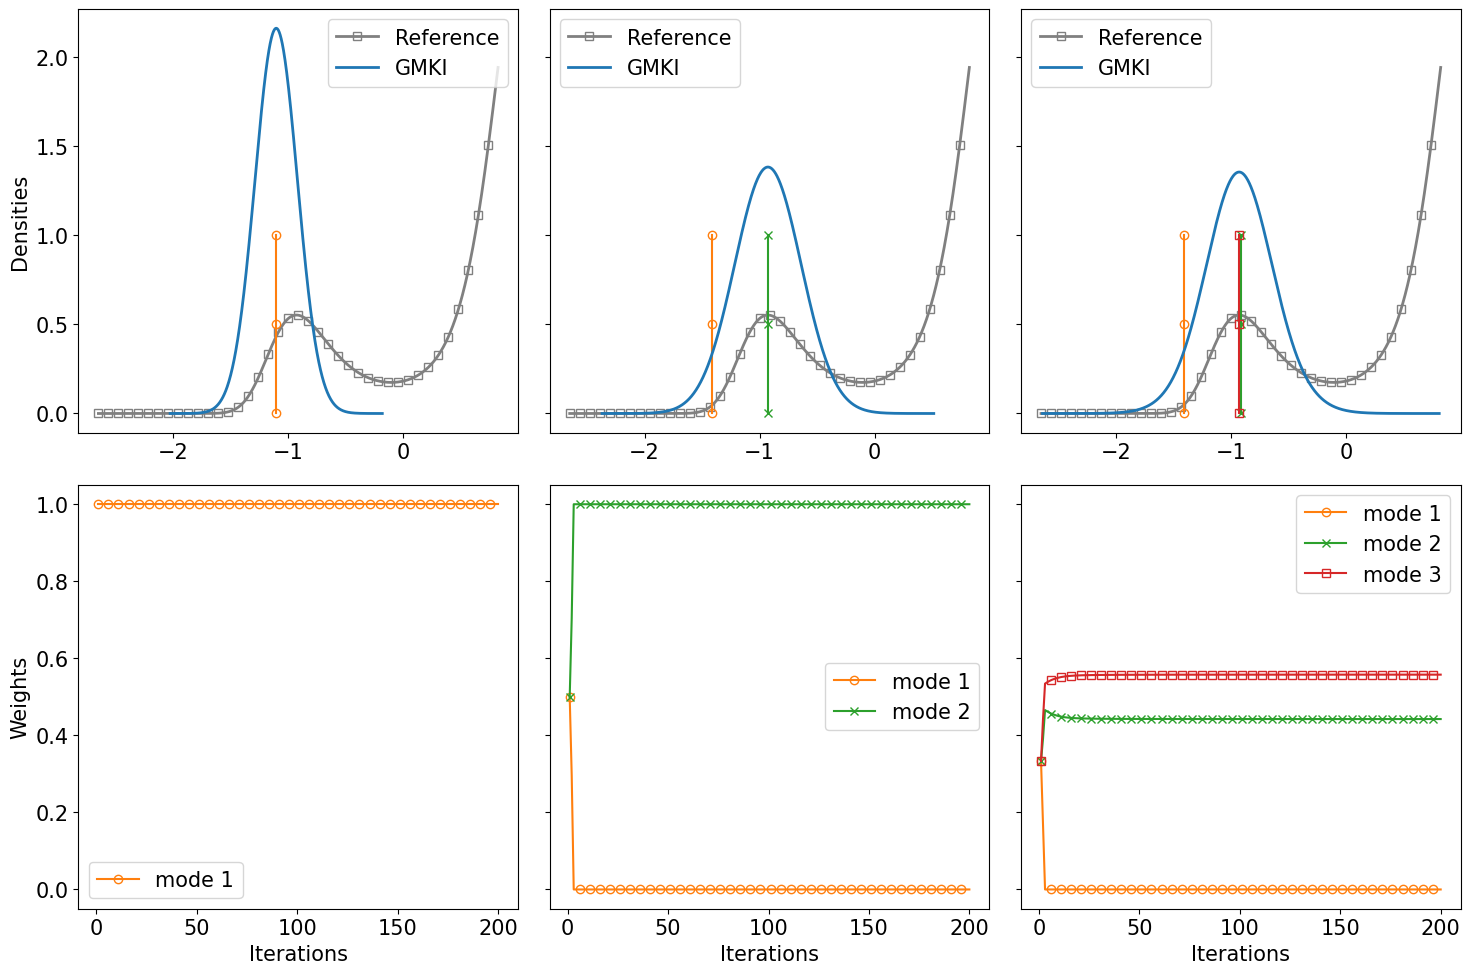

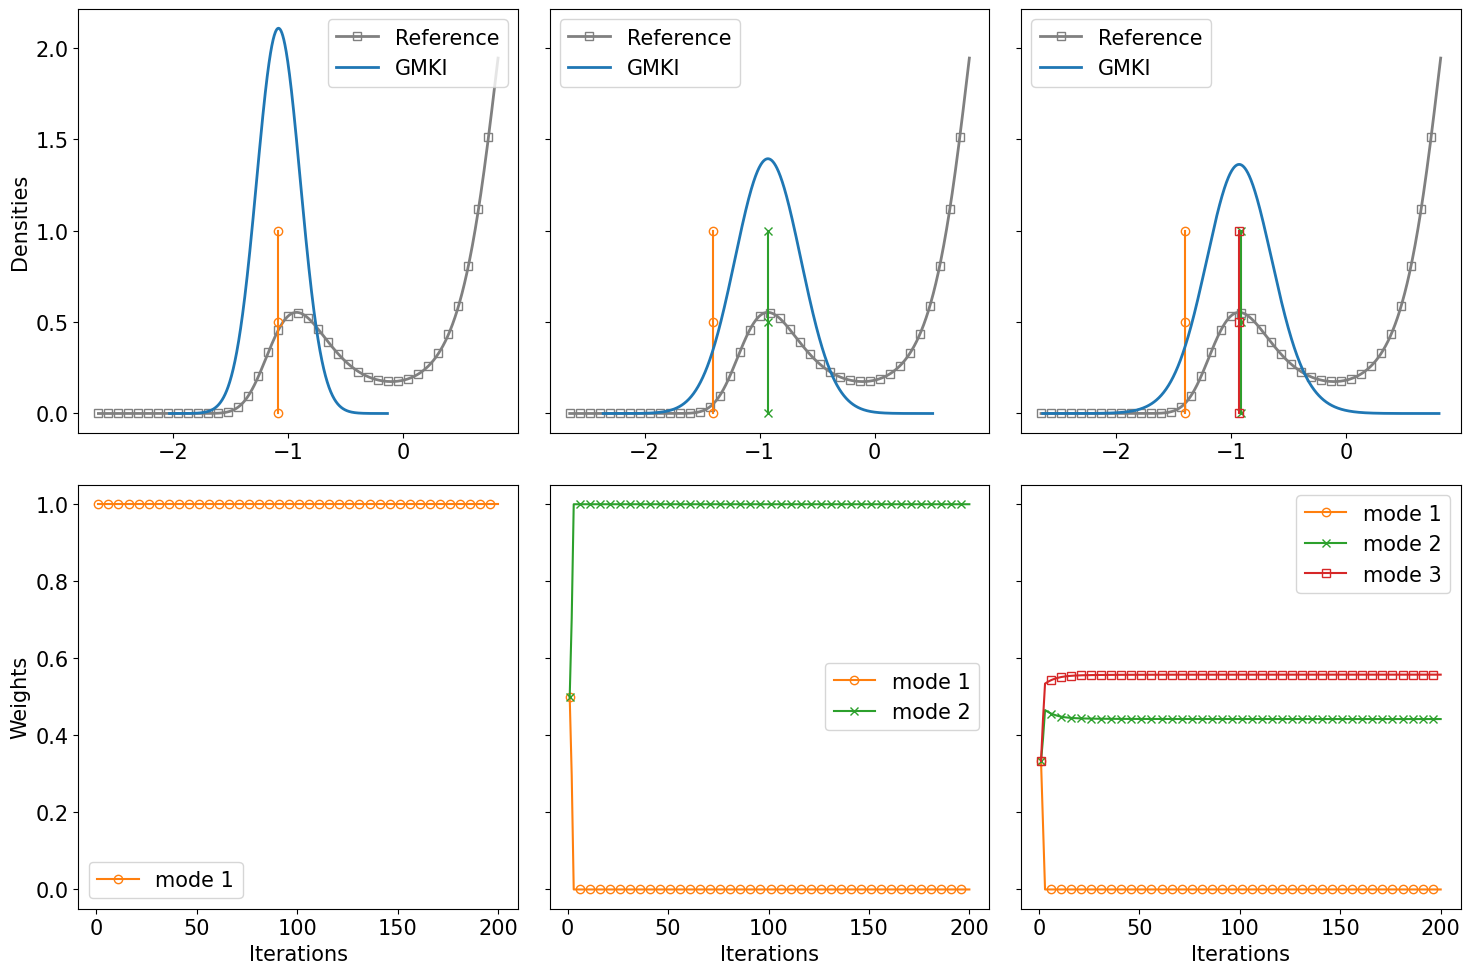

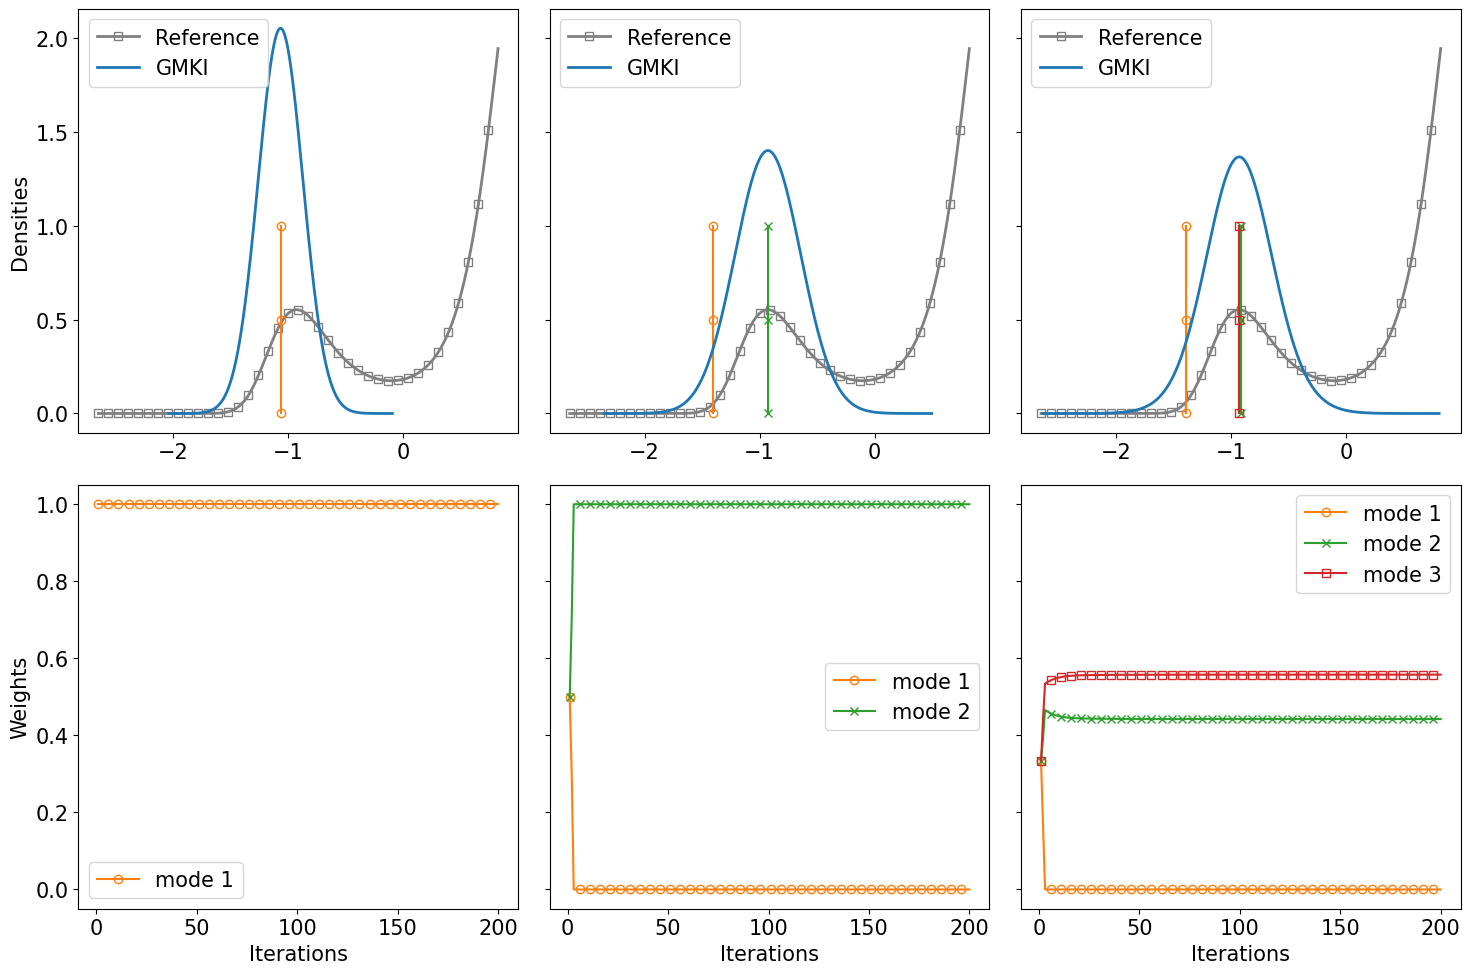

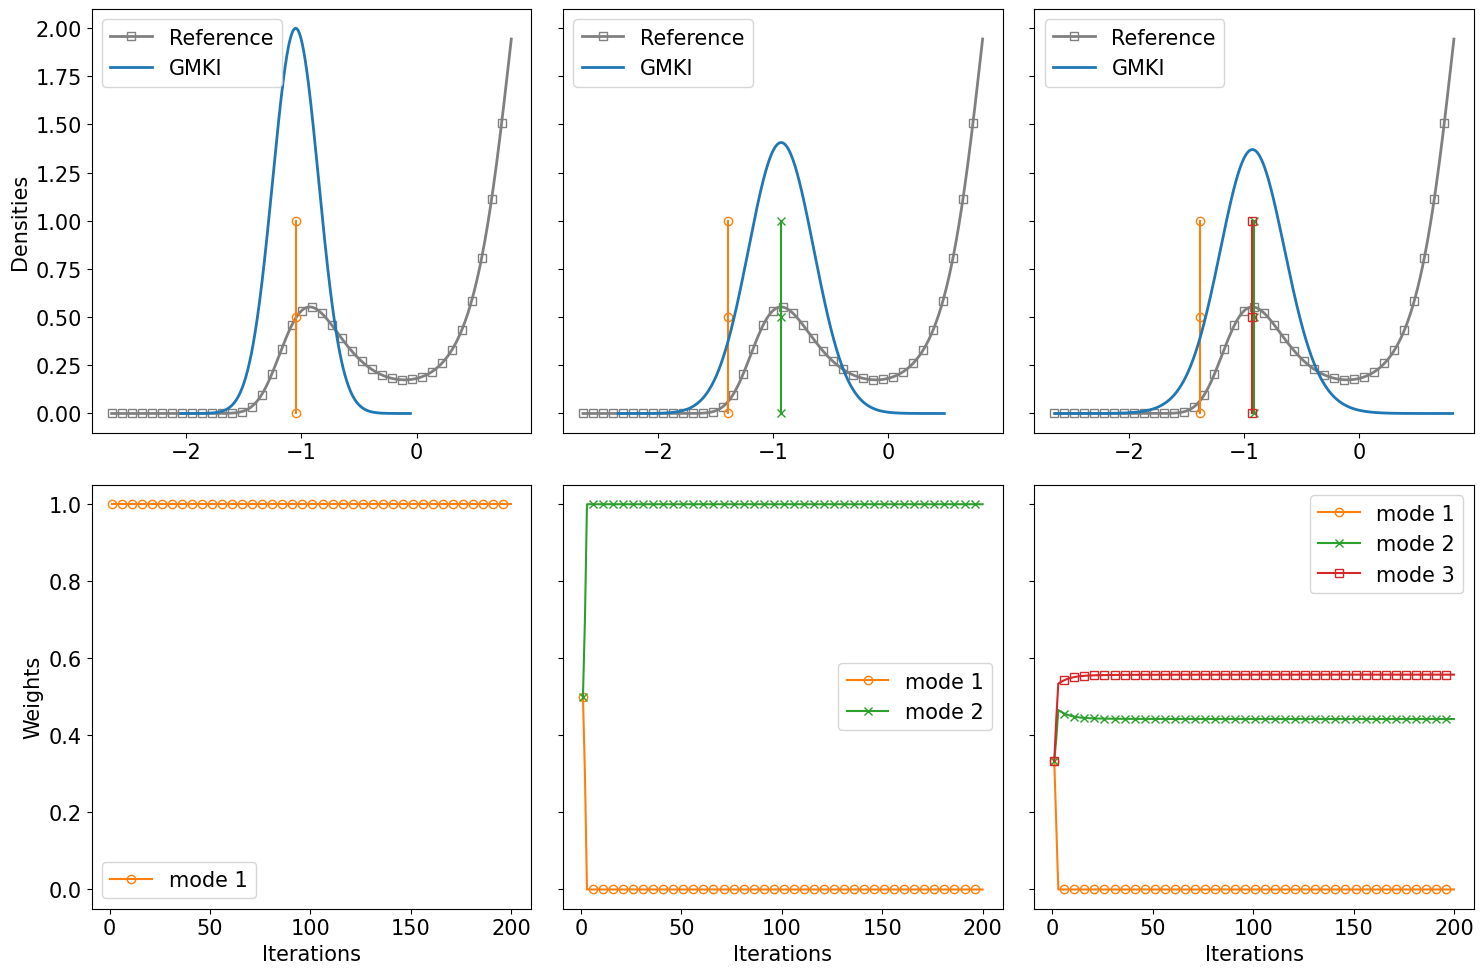

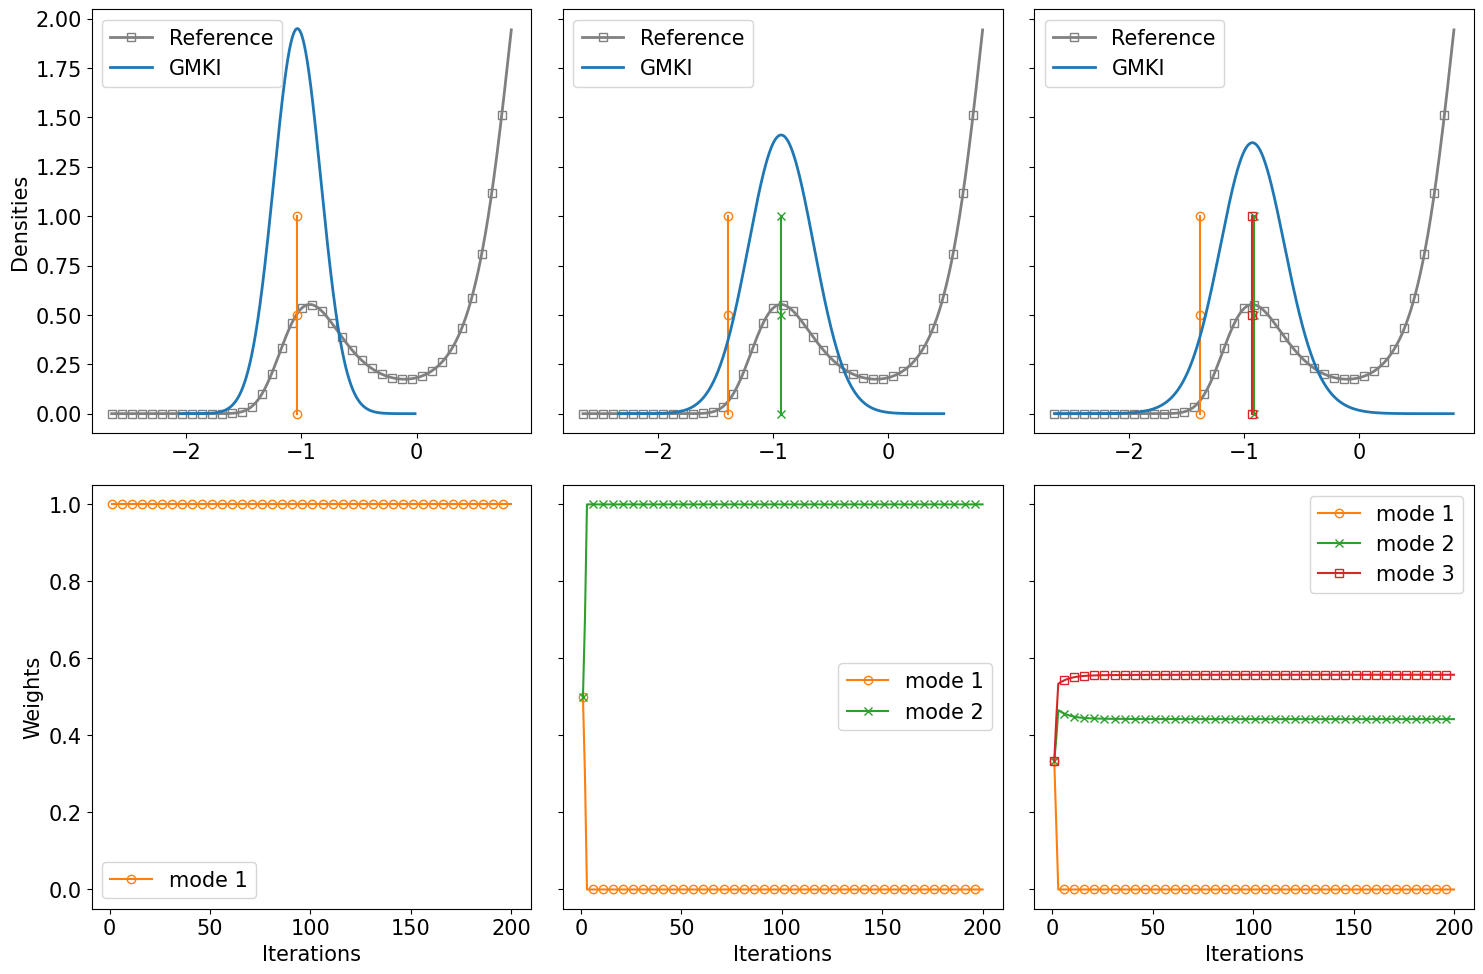

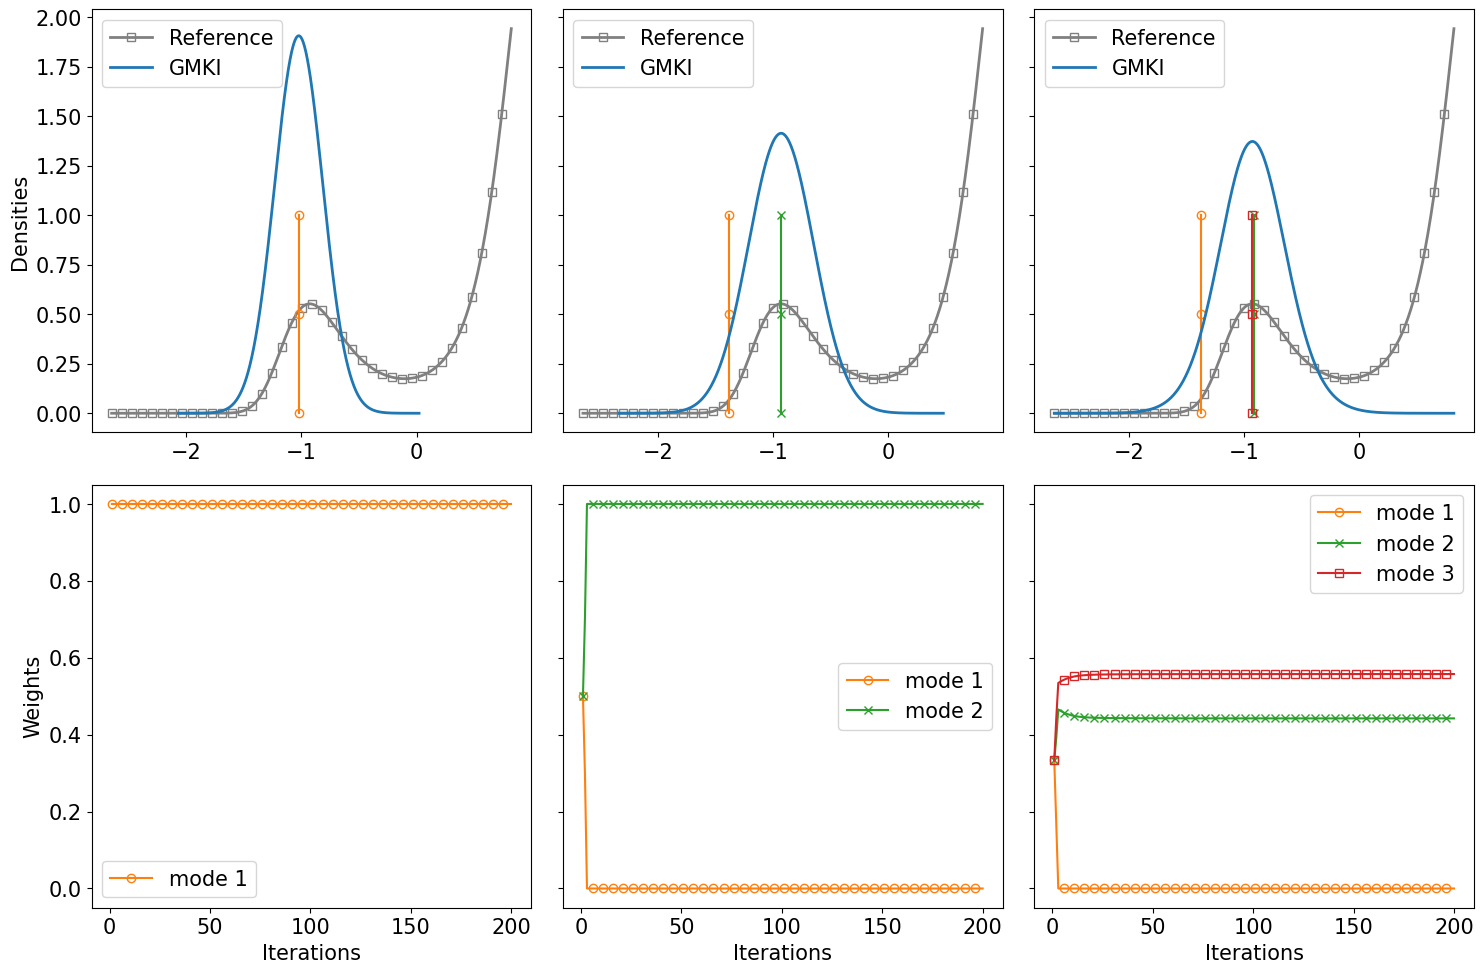

┌ Info: ("Run GMGD with ", 1, " θ0_mean = ", [-2.4283140297584804;;])
└ @ Main In[43]:36
┌ Info: ("Run GMGD with ", 2, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095;;])
└ @ Main In[43]:36
┌ Info: ("Run GMGD with ", 3, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095; -0.894645096090581;;])
└ @ Main In[43]:36
sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


In [44]:
Posterior_Plot(p2; θ_ref = 1.0, σ_η = 0.5, μ_0 = 3.2,  σ_0 = 2.0,  plot_every = 5) 

